# Import Libraries and Load Data:

- Load Libraries
- change working directory
- unzip input data
- remove zip data

In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
import logging

In [ ]:
logging.basicConfig(filename="log.txt", level=logging.DEBUG,
                    format="%(levelname)s %(asctime)s %(message)s", filemode="a")

In [ ]:
os.chdir(r'/content/drive/MyDrive/AppliedAI/self_case_study_1/ashrae_energy_prediction')

In [ ]:
# !unzip 'data/input_data/ashrae-energy-prediction.zip' -d 'data/input_data'

In [ ]:
# os.remove('data/input_data/ashrae-energy-prediction.zip')

In [ ]:
#https://towardsdatascience.com/how-to-reduce-the-size-of-a-pandas-dataframe-in-python-7ed6e4269f88
def compress(df, verbose=True):
    ## downcasting loop
    start_mem = np.round(df.memory_usage().sum() / 1024**2, 3)
    for column in df:
        if df[column].dtype == 'float64':
            df[column]=pd.to_numeric(df[column], downcast='float')
        if (df[column].dtype== 'int64') or (df[column].dtype== 'int32'):
            df[column]=pd.to_numeric(df[column], downcast='integer')
    end_mem = np.round(df.memory_usage().sum() / 1024**2, 3)
    if verbose:
        print(f"Memory usage reduced to {end_mem:8} MB: Memory reduction by {(start_mem-end_mem)*100/start_mem}%")
    return df

def read_building_data(input_data_path):
    return compress(pd.read_csv(os.path.join(input_data_path, 'building_metadata.csv')))
def read_train_data(input_data_path):
    return compress(pd.read_csv(os.path.join(input_data_path, 'train.csv'), parse_dates=['timestamp']))
def read_test_data(input_data_path):
    return compress(pd.read_csv(os.path.join(input_data_path, 'test.csv'), parse_dates=['timestamp']))
def read_weather_train_data(input_data_path):
    return compress(pd.read_csv(os.path.join(input_data_path, 'weather_train.csv'), parse_dates=['timestamp']))
def read_weather_test_data(input_data_path):
    return compress(pd.read_csv(os.path.join(input_data_path, 'weather_test.csv'), parse_dates=['timestamp']))
def read_all_data(input_data_path):
    return read_building_data(input_data_path), read_train_data(input_data_path),\
           read_test_data(input_data_path), read_weather_train_data(input_data_path),\
           read_weather_test_data(input_data_path)

In [ ]:
building_metadata_df, train_df, test_df, weather_train_df, weather_test_df = read_all_data('data/input_data')

In [ ]:
pickle.dump(building_metadata_df, open('data/input_data/building_metadata_df.pkl', 'wb'))
pickle.dump(train_df, open('data/input_data/train_df.pkl', 'wb'))
pickle.dump(test_df, open('data/input_data/test_df.pkl', 'wb'))
pickle.dump(weather_train_df, open('data/input_data/weather_train_df.pkl', 'wb'))
pickle.dump(weather_test_df, open('data/input_data/weather_test_df.pkl', 'wb'))

# Preprocess

## building data

In [ ]:
def preprocess_building_data(building_metadata_df, train=True):
    df = building_metadata_df.copy()
    #floor_count
    df['floor_count'].fillna(0, inplace=True)
    df['floor_count'] = (df['floor_count'] + 1).astype(np.int8) #we treat ground floor as 1 floor_count
    #square_feet
    df['log_sq_ft'] = np.log(df['square_feet']).astype(np.float16)
    #primary_use
    df['primary_use'] = df.primary_use.str.lower().replace(re.compile(r'(/| )'), "_")
    if train:
        primary_use_label = sorted(df.primary_use.unique())
        primary_use_label_map = {label:i for i, label in enumerate(primary_use_label, start=1)}
        primary_use_label_map['UNK'] = 0
        pickle.dump(primary_use_label_map, open('data/processed_data/primary_use_label_map.pkl', 'wb'))
    else:
        primary_use_label_map = pickle.load(open('data/processed_data/primary_use_label_map.pkl', 'rb'))
    df['primary_use'] = df.primary_use.replace(primary_use_label_map).astype(np.int8)
    #year_built
    bins = np.arange(0, 201, 25)
    labels = np.arange(1, bins.shape[0])
    df['year_built'] = df['year_built'] - 1900 + 1
    df['year_built_label'] = pd.cut(df['year_built'], bins = bins , labels = labels,
                             include_lowest = True, ordered=False).astype(np.float16).fillna(0).astype(np.int8)
    df['year_built'] = df['year_built'].fillna(0).astype(np.int32)
    df = compress(df)
    assert df.isna().sum().sum() == 0
    return df

## weather data

In [ ]:
def weather_preprocessing_pipleine(df, year=[2016], apply_offset=True, offsets=None):
    #return preprocessed weather data
    logging.debug("Weather data preprocessing started...")
    print("Weather data preprocessing started...")
    try:
        logging.debug("Checking file type of parameter year...")
        assert isinstance(year, list), "Please provide year in list format"
        if apply_offset:
            logging.debug("Checking file type of parameter offsets...")
            assert isinstance(offsets, list) if offsets is not None else True, "offsets should be a list"
            logging.debug("Verifying length of offsets with number of unique site_id...")
            assert df.site_id.unique().shape[0] == len(offsets) if offsets is not None else True,\
                "length of offsets should match unique site_id"
    except AssertionError as e:
        logging.error(e)
        print(e)
        return df
    logging.debug("Input data verified. Vreating a copy for input data for preprocessing...")
    print("Input data verified. Vreating a copy for input data for preprocessing...")
    df = df.copy()
    logging.debug("Checking for apply_offset condition...")
    if apply_offset:
        logging.debug("apply_offset = True")
        logging.debug("checking for input offsets...")
        if offsets is None:
            logging.debug("offsets not provided. Will use default offsets list")
            print("offsets not provided. Will use default offsets list")
            offsets = [-5, 0, -7, -5, -8, 0, -5, -5, -5, -6, -7, -5, 0, -6, -5, -5]
        #apply offset based on site_id
        logging.debug("Applying offset based on site_id")
        print("Applying offset based on site_id")
        for site_id, offset in enumerate(offsets):
            logging.debug(f"site_id == {site_id}")
            row_condition = df['site_id'] == site_id
            df.loc[row_condition, 'timestamp'] = df.timestamp + pd.to_timedelta(offset, unit='h')
        #filter values other than year provided
        logging.debug("Filtering input data by year...")
        print("Filtering input data by year...")
        print("Before filter...")
        print(df.shape)
        filter_by_year = (df.timestamp.dt.year.isin(year))
        df = df.loc[filter_by_year, :]
        logging.debug(f"After filtering input shape: {df.shape}")
        print("After filter...")
        print(df.shape)
    #func1 apply linear interpolation for missing timestamp
    logging.debug(f"Applying func1 on input data...")
    print("Before func1...")
    print(df.isna().sum())
    weather_train_df_p = df.groupby('site_id').apply(lambda group: func1(group))
    #func1 post processing
    print("After func1...")
    print(weather_train_df_p.isna().sum())
    logging.debug(f"Applying func1 post processing on input data...")
    weather_train_df_p = weather_train_df_p.reset_index(drop=True)
    print("After func1 post processing...")
    print(weather_train_df_p.isna().sum())
    #compute median value of preprocessed weather data
    logging.debug(f"Computing median value of preprocessed data at given timestamp...")
    impute_weather_data = weather_train_df_p.groupby(['timestamp']).median()
    #there are still some columns remaining for which we do not have any value to impute
    #for such columns we impute hourly median data
    logging.debug("Applying func2: Imputing remaining features by median values at given timestamp...")
    print("Applying func2: Imputing remaining features by median values at given timestamp...")
    weather_train_df_p = weather_train_df_p.groupby('site_id').apply(lambda group: func2(group, impute_weather_data))
    print("After Applying func2...")
    print(weather_train_df_p.isna().sum())
    logging.debug(f"Weather data preprocessing completed...")
    return weather_train_df_p

def func2(data, impute_weather_data):
    df = data.copy()
    logging.debug(f"Site Id: {df['site_id'].iloc[0]}")
    site_id = df['site_id'].iloc[0]
    logging.debug(df.isna().sum())
    cols = sorted(df.isna().sum().index[(df.isna().sum() > 0)])
    logging.debug(f"columns with missing values: {cols}")
    if len(cols)>0:
        df.loc[:, cols] = impute_weather_data[cols].values
        try:
            assert df.isna().sum().sum()==0,\
             f"Some values are still missing in site {site_id}"
        except AssertionError as e:
            logging.error(e)
    else:
        logging.debug("Nan value not found return as it is")
    logging.debug("=" * 80)
    return df

def func1(data):
    df = data.copy()
    #fill missing timestamp with nan
    logging.debug(f"Site Id: {df['site_id'].iloc[0]}")
    site_id = df['site_id'].iloc[0]
    min_year = df.timestamp.dt.year.min()
    max_year = df.timestamp.dt.year.max()
    logging.debug(f"Min year: {min_year}")
    logging.debug(f"Max year: {max_year}")
    delta=1
    df = df.set_index('timestamp')
    new_timestamp = pd.date_range(f'{min_year}-01-01', f'{max_year+delta}-01-01', freq='H', closed='left', name='timestamp')
    df = df.reindex(new_timestamp).reset_index()
    #interpolate missing value
    cols = sorted(set(df.columns) - {'timestamp', 'site_id'})
    logging.debug("Before interpolation...")
    logging.debug(df.isna().sum())
    df[cols] = df[cols].interpolate(method='linear', limit_direction='both', axis=0)
    df.loc[:, 'site_id'] = site_id
    logging.debug("=" * 40)
    logging.debug("After interpolation...")
    logging.debug(df.isna().sum())
    logging.debug("=" * 80)
    return df

def _add_past_feature_(data, window=18):
    df = data.copy()
    col = ["air_temperature", "cloud_coverage","dew_temperature", "precip_depth_1_hr"]
    df_rolled = df.groupby("site_id")[["air_temperature", "cloud_coverage",
                                       "dew_temperature", "precip_depth_1_hr"]]\
                                       .rolling(window=window, min_periods=0)

    df_max = df_rolled.max().reset_index()
    df_min = df_rolled.min().reset_index()
    df_mean = df_rolled.mean().reset_index()
    df_median = df_rolled.median().reset_index()
    df_std = df_rolled.std().reset_index()

    print(df_max.isna().sum())
    print(df_min.isna().sum())
    print(df_mean.isna().sum())
    print(df_median.isna().sum())
    print(df_std.isna().sum())

    for column in col:
        df[f"{column}_max_past_{window}"] = df_max[column]
        df[f"{column}_min_past_{window}"] = df_min[column]
        df[f"{column}_mean_past_{window}"] = df_mean[column]
        df[f"{column}_median_past_{window}"] = df_median[column]
        df[f"{column}_std_past_{window}"] = df_std[column]
    # df.drop(columns=col, inplace=True)

    print(df.isna().sum())
    print('Filling nan values...')
    df.fillna(method='bfill', inplace=True)

    for column in col:
        df[f"{column}_max_past_{window}"] = df[f"{column}_max_past_{window}"].astype(np.float16)
        df[f"{column}_min_past_{window}"] = df[f"{column}_min_past_{window}"].astype(np.float16)
        df[f"{column}_mean_past_{window}"] = df[f"{column}_mean_past_{window}"].astype(np.float16)
        df[f"{column}_median_past_{window}"] = df[f"{column}_median_past_{window}"].astype(np.float16)
        df[f"{column}_std_past_{window}"] = df[f"{column}_std_past_{window}"].astype(np.float16)

    return df

def get_sin_hour(hour):
    return np.sin((hour+13)*2*np.pi/24)

def get_sin_month(month):
    return np.sin((month+0.5)*2*np.pi/24)

def get_wind_direction_label(direction_in_deg):
    return np.sin(2*np.pi*(direction_in_deg+90)/360)

def weather_fe_pipeline(data):
    df = data.copy()
    df = _add_past_feature_(data=df, window=18)

    #add basic time data like month, dayofweek, hour
    df = df.assign(month=df.timestamp.dt.month,
                   dayofweek=df.timestamp.dt.dayofweek,
                   hour=df.timestamp.dt.hour)\
                   .astype({'month':np.int8,
                            'dayofweek':np.int8,
                            'hour':np.int8})

    df = df.assign(sin_hour = get_sin_hour(df['hour']),
                   sin_month = get_sin_month(df['month']),
                   sin_wind_direction = get_wind_direction_label(df['wind_direction']))\
                   .astype({'sin_hour':np.float16,
                            'sin_month':np.float16,
                            'sin_wind_direction':np.float16})

    df['wind_direction'] = df['wind_direction'].replace({360:0}) // 45

    df = df.astype({'air_temperature':np.float16,
                    'cloud_coverage':np.float16,
                    'dew_temperature':np.float16,
                    'precip_depth_1_hr':np.float16,
                    'sea_level_pressure':np.float16,
                    'wind_speed':np.float16,
                    'wind_direction':np.int8})
    return df

In [ ]:
#load raw compressed data
train_df = pickle.load(open('data/input_data/train_df.pkl', 'rb'))
test_df = pickle.load(open('data/input_data/test_df.pkl', 'rb'))
weather_train_df = pickle.load(open('data/input_data/weather_train_df.pkl', 'rb'))
weather_test_df = pickle.load(open('data/input_data/weather_test_df.pkl', 'rb'))
building_metadata_df = pickle.load(open('data/input_data/building_metadata_df.pkl', 'rb'))

In [ ]:
p_weather_train_df = weather_preprocessing_pipleine(df=weather_train_df, year=[2016], apply_offset=True, offsets=None)
p_weather_test_df = weather_preprocessing_pipleine(df=weather_test_df, year=[2017,2018], apply_offset=True, offsets=None)

In [ ]:
fe_weather_train_df = weather_fe_pipeline(data=p_weather_train_df)
fe_weather_test_df = weather_fe_pipeline(data=p_weather_test_df)

In [ ]:
p_building_metadata_df = preprocess_building_data(building_metadata_df, train=True)

Memory usage reduced to    0.018 MB: Memory reduction by 18.181818181818183%


## meter_data

In [ ]:
def preprocess_train_data(train_df, building_metadata_df):
    p_train_df = train_df.copy()
    p_train_df = p_train_df.merge(building_metadata_df[['building_id', 'site_id']], on='building_id', how='left')
    assert p_train_df.shape[0] == train_df.shape[0]
    p_train_df = p_train_df.pivot(columns=['meter', 'site_id', 'building_id'], index='timestamp', values='meter_reading')
    df_roll_sum = p_train_df.rolling(window=48, min_periods=0).sum()
    df_roll_sum = df_roll_sum.unstack().rename(index='meter_reading_sum').reset_index()
    p_train_df = p_train_df.unstack().rename(index='meter_reading').reset_index()
    df_roll_sum.drop(columns='site_id', inplace=True)
    p_train_df = p_train_df.merge(df_roll_sum, on=['meter', 'building_id', 'timestamp'], how='left')
    del df_roll_sum
    #remove 48 hour streak of electrical reading
    condition = (p_train_df['meter'] == 0) & (p_train_df['meter_reading_sum'] == 0)
    p_train_df = p_train_df[~condition]
    #remove 0 hotwater/steam reading in core winter season for window of 48 hours
    condition = ((p_train_df['meter'] == 2)|(p_train_df['meter'] == 3)) &\
                (p_train_df['meter_reading_sum'] == 0) & \
                (p_train_df['timestamp'].dt.month.isin([1,2,3,4,12]))
    p_train_df = p_train_df[~condition]
    #remove 0 coldwater reading in core summer season for window of 48 hours
    condition = (p_train_df['meter'] == 1) &\
                (p_train_df['meter_reading_sum'] == 0) & \
                (p_train_df['timestamp'].dt.month.isin([4,5,6,7,8,9,10]))
    p_train_df = p_train_df[~condition]
    p_train_df.drop(columns='meter_reading_sum', inplace=True)
    #remove site 0 meter 0 reading for first 140 days
    condition = (p_train_df.meter==0) & (p_train_df.site_id==0) & (p_train_df.timestamp.dt.dayofyear<141)
    p_train_df = p_train_df[~condition]
    p_train_df = compress(p_train_df)
    #remove outliers
    condition = (p_train_df['building_id'] == 1099) & (p_train_df['meter'] == 2) & (p_train_df['meter_reading'] > 350000)
    p_train_df = p_train_df[~condition]
    return p_train_df

In [ ]:
p_train_df = preprocess_train_data(train_df, building_metadata_df)

Memory usage reduced to  454.081 MB: Memory reduction by 45.45455637479249%


In [ ]:
p_train_df.dropna(inplace=True)

In [ ]:
temp = p_train_df.pivot(index=['meter', 'building_id'], columns='timestamp',
                      values='meter_reading')

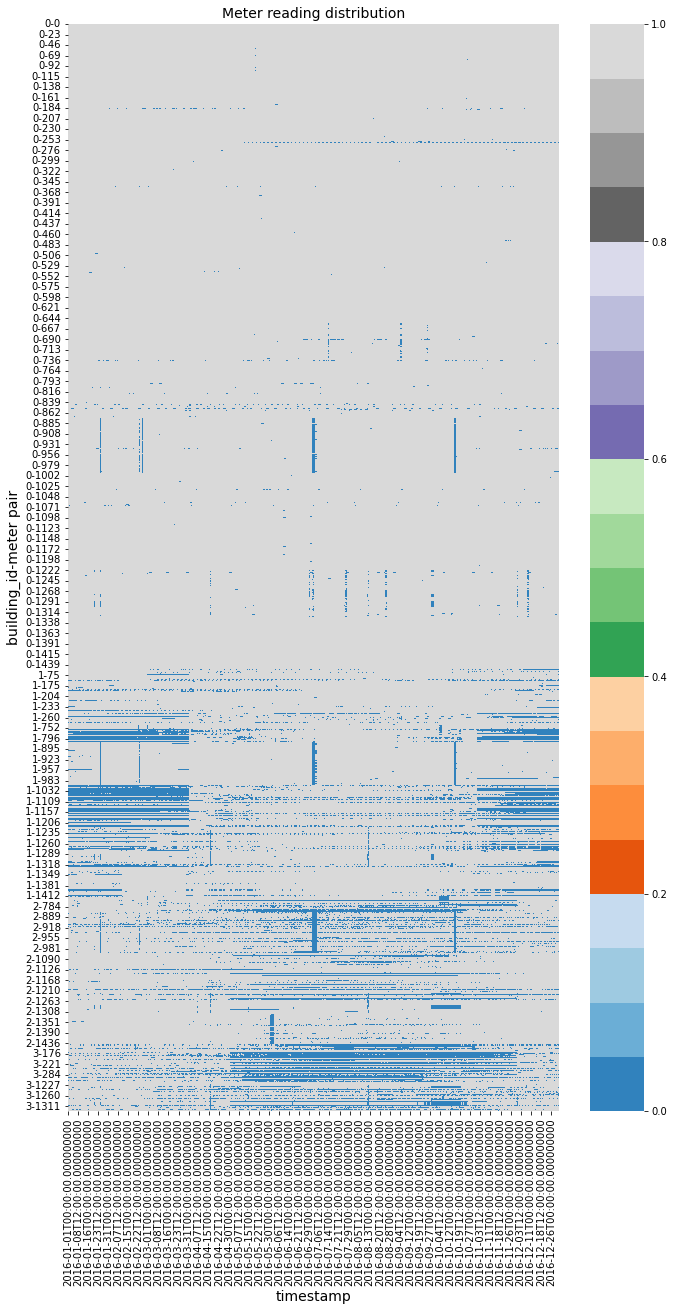

In [ ]:
#visualize zero reading distribution
plt.figure(figsize=(11,20))
sns.heatmap((temp!=0).astype('int8'), cmap='tab20c')
plt.title("Meter reading distribution", fontsize=14)
plt.xlabel('timestamp', fontsize=14)
plt.ylabel('building_id-meter pair', fontsize=14)
plt.show()

In [ ]:
p_train_df = p_train_df.assign(quarter=p_train_df.timestamp.dt.quarter)\
                               .astype({'quarter':np.int8})
p_train_df.drop(columns=['site_id'], inplace=True)

In [ ]:
test_df = test_df.assign(quarter=test_df.timestamp.dt.quarter)\
                 .astype({'quarter':np.int8})

In [ ]:
final_data = p_train_df.merge(p_building_metadata_df, on=['building_id'], how='left')\
                       .merge(fe_weather_train_df, on=['site_id', 'timestamp'], how='left')

In [ ]:
test_df_2017 = test_df[test_df.timestamp.dt.year==2017]
test_df_2018 = test_df[test_df.timestamp.dt.year==2018]

In [ ]:
del test_df

In [ ]:
test_data_2017 = test_df_2017.merge(p_building_metadata_df, on=['building_id'], how='left')\
                             .merge(fe_weather_test_df, on=['site_id', 'timestamp'], how='left')

test_data_2018 = test_df_2018.merge(p_building_metadata_df, on=['building_id'], how='left')\
                             .merge(fe_weather_test_df, on=['site_id', 'timestamp'], how='left')

In [ ]:
if not os.path.exists(os.path.join('data', 'final_data')):
    os.makedirs(os.path.join('data', 'final_data'))

In [ ]:
final_data.isna().sum().sum()

0

In [ ]:
pickle.dump(final_data, open(os.path.join('data', 'final_data', 'final_data.pkl'), 'wb'))
del final_data
pickle.dump(test_data_2017, open(os.path.join('data', 'final_data', 'test_data_2017.pkl'), 'wb'))
del test_data_2017
pickle.dump(test_data_2018, open(os.path.join('data', 'final_data', 'test_data_2018.pkl'), 'wb'))
del test_data_2018

# First Cut Solution

- First Cut Solution:<br>
As a first cut solution we can start with simple moving average,
weighted moving average and exponential moving average model
- Alternate Solution:<br>
    - Above solution cannot be applied here as we are not having immediate past reading at our disposal. We are provided with 2016 meter reading and we need to predict 2017-2018 (2 year reading).
    - Further we can leverage weather metadata and building metadata to
build linear models like logistic regression and other non linear model
like SVR(kernel based), RF, GBDT.


In [ ]:
#load raw compressed data
train_df = pickle.load(open('data/input_data/train_df.pkl', 'rb'))
weather_train_df = pickle.load(open('data/input_data/weather_train_df.pkl', 'rb'))
building_metadata_df = pickle.load(open('data/input_data/building_metadata_df.pkl', 'rb'))

In [ ]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [ ]:
train_df.isna().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [ ]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.0,NaN,1019.700012,0.0,0.0
1,0,2016-01-01 01:00:00,24.400000,NaN,21.1,-1.0,1020.200012,70.0,1.5
2,0,2016-01-01 02:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0
3,0,2016-01-01 03:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0
4,0,2016-01-01 04:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6


In [ ]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [ ]:
building_metadata_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [ ]:
building_metadata_df.isna().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

In [ ]:
#preprocess raw compressed data
p_train_df = preprocess_train_data(train_df)
p_weather_train_df = preprocess_weather_data(weather_train_df)
p_building_metadata_df = preprocess_building_data(building_metadata_df)

In [ ]:
p_train_df.isna().sum()

building_id          0
meter                0
timestamp            0
meter_reading        0
log_meter_reading    0
dtype: int64

In [ ]:
p_weather_train_df.isna().sum()

timestamp             0
site_id               0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [ ]:
p_building_metadata_df.isna().sum()

site_id             0
building_id         0
primary_use         0
square_feet         0
year_built          0
floor_count         0
log_sq_ft           0
year_built_label    0
dtype: int64

In [ ]:
pickle.dump(p_building_metadata_df, open('data/processed_data/p_building_metadata_df.pkl', 'wb'))
pickle.dump(p_train_df, open('data/processed_data/p_train_df.pkl', 'wb'))
pickle.dump(p_weather_train_df, open('data/processed_data/p_weather_train_df.pkl', 'wb'))

## Prepare Data

In [ ]:
p_building_metadata_df = pickle.load(open('data/processed_data/p_building_metadata_df.pkl', 'rb'))
p_train_df = pickle.load(open('data/processed_data/p_train_df.pkl', 'rb'))
p_weather_train_df = pickle.load(open('data/processed_data/p_weather_train_df.pkl', 'rb'))

In [ ]:
final_data = p_train_df.merge(p_building_metadata_df, on=['building_id'], how='left')\
                       .merge(p_weather_train_df, on=['site_id', 'timestamp'], how='left')
final_data.head(2)

,building_id,meter,timestamp,meter_reading,log_meter_reading,site_id,primary_use,square_feet,year_built,floor_count,log_sq_ft,year_built_label,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0.0,0,1,7432,109,1,8.914062,5,25.0,6.0,20.0,-1.0,1019.700012,0.0,0.0
1,1,0,2016-01-01,0.0,0.0,0,1,2720,105,1,7.910156,5,25.0,6.0,20.0,-1.0,1019.700012,0.0,0.0


In [ ]:
def add_time_based_features(data):
    df = data.copy()
    df['dayofweek'] = df.timestamp.dt.dayofweek
    df['hour'] = df.timestamp.dt.hour
    df['month'] = df.timestamp.dt.month
    return df

In [ ]:
def FE(data):
    df = data.copy()
    df = df.assign(floor_sq_ft = df['log_sq_ft'] * df['floor_count'])
    return df

In [ ]:
final_data = add_time_based_features(final_data)
final_data = FE(final_data)

In [ ]:
final_data.isna().sum()

building_id           0
meter                 0
timestamp             0
meter_reading         0
log_meter_reading     0
site_id               0
primary_use           0
square_feet           0
year_built            0
floor_count           0
log_sq_ft             0
year_built_label      0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dayofweek             0
hour                  0
floor_sq_ft           0
month                 0
dtype: int64

In [ ]:
final_data = compress(final_data)

Memory usage reduced to  1368.85 MB: Memory reduction by 22.826081441218776%


## Time Based Split

In [ ]:
final_data_train, final_data_test = final_data[final_data.timestamp.dt.month <= 6], final_data[final_data.timestamp.dt.month > 6]

In [ ]:
final_data_train.shape, final_data_test.shape

((9898185, 23), (10317915, 23))

In [ ]:
df1 = final_data_train.groupby(['building_id', 'meter', 'dayofweek']).agg(week_day_mean = ('log_meter_reading', 'mean')).reset_index()
df2 = final_data_train.groupby(['building_id', 'meter', 'month', 'dayofweek']).agg(month_week_day_mean = ('log_meter_reading', 'mean')).reset_index()

In [ ]:
df1.head(2)

,building_id,meter,dayofweek,week_day_mean
0,0,0,0,1.255189
1,0,0,1,1.258958


In [ ]:
df2.head()

,building_id,meter,month,dayofweek,month_week_day_mean
0,0,0,1,0,0.0
1,0,0,1,1,0.0
2,0,0,1,2,0.0
3,0,0,1,3,0.0
4,0,0,1,4,0.0


In [ ]:
df_train = df2.merge(df1, on=['building_id', 'meter', 'dayofweek'])
df_train.shape

(97634, 6)

In [ ]:
df_train = compress(df_train)

Memory usage reduced to    1.955 MB: Memory reduction by 56.25419556947863%


In [ ]:
df_test = final_data_test.groupby(['building_id', 'meter', 'month', 'dayofweek']).agg(month_week_day_mean = ('log_meter_reading', 'mean')).reset_index()
df_test.shape

(99438, 5)

In [ ]:
df_test.head()

,building_id,meter,month,dayofweek,month_week_day_mean
0,0,0,7,0,5.621617
1,0,0,7,1,5.597899
2,0,0,7,2,5.649213
3,0,0,7,3,5.634453
4,0,0,7,4,5.639638


In [ ]:
df_test = compress(df_test)

Memory usage reduced to    0.854 MB: Memory reduction by 74.98535442296426%


In [ ]:
df_test.shape

(99438, 5)

In [ ]:
df_train = df_train.assign(sin_month = np.sin(df_train.month),
                           cos_month = np.cos(df_train.month))
df_test = df_test.assign(sin_month = np.sin(df_test.month),
                         cos_month = np.cos(df_test.month))

In [ ]:
X_train = df_train.drop(columns=['month', 'month_week_day_mean'])
y_train = df_train['month_week_day_mean']

In [ ]:
X_train.head()

,building_id,meter,dayofweek,week_day_mean,sin_month,cos_month
0,0,0,0,1.255189,0.841309,0.540527
1,0,0,0,1.255189,0.909180,-0.416260
2,0,0,0,1.255189,0.141113,-0.990234
3,0,0,0,1.255189,-0.756836,-0.653809
4,0,0,0,1.255189,-0.958984,0.283691


In [ ]:
df_test.shape, df_train.shape

((99438, 7), (97634, 8))

In [ ]:
temp = df_train.drop_duplicates(subset=['building_id', 'meter', 'dayofweek'])
temp.shape

(16582, 8)

In [ ]:
temp.head()

,building_id,meter,month,dayofweek,month_week_day_mean,week_day_mean,sin_month,cos_month
0,0,0,1,0,0.0,1.255189,0.841309,0.540527
6,0,0,1,1,0.0,1.258958,0.841309,0.540527
12,0,0,1,2,0.0,1.269639,0.841309,0.540527
18,0,0,1,3,0.0,1.269771,0.841309,0.540527
24,0,0,1,4,0.0,1.119378,0.841309,0.540527


In [ ]:
df_test = df_test.merge(temp[['building_id', 'meter', 'dayofweek', 'week_day_mean']], how='left')
df_test.shape

(99438, 8)

In [ ]:
df_test.head(2)

,building_id,meter,month,dayofweek,month_week_day_mean,sin_month,cos_month,week_day_mean
0,0,0,7,0,5.621617,0.657227,0.753906,1.255189
1,0,0,7,1,5.597899,0.657227,0.753906,1.258958


In [ ]:
X_test = df_test.drop(columns=['month', 'month_week_day_mean'])
y_test = df_test['month_week_day_mean']

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
ohe= OneHotEncoder()

In [ ]:
ohe.fit(X_train[['building_id', 'meter', 'dayofweek']])

OneHotEncoder()

In [ ]:
ohe.categories_

[array([   0,    1,    2, ..., 1446, 1447, 1448], dtype=int16),
 array([0, 1, 2, 3], dtype=int8),
 array([0, 1, 2, 3, 4, 5, 6], dtype=int8)]

In [ ]:
ohe_vec_test = ohe.transform(X_test[['building_id', 'meter', 'dayofweek']])
ohe_vec_train = ohe.transform(X_train[['building_id', 'meter', 'dayofweek']])

ValueError: ignored

In [ ]:
from scipy.sparse import coo_matrix, hstack

In [ ]:
X_train_ = hstack([ohe_vec_train, X_train[['sin_month', 'cos_month', 'week_day_mean']]]).tocsr()
X_train_

<97634x1456 sparse matrix of type '<class 'numpy.float64'>'
	with 585166 stored elements in Compressed Sparse Row format>

In [ ]:
X_test_ = hstack([ohe_vec_test, X_test[['sin_month', 'cos_month', 'week_day_mean']]]).tocsr()
X_test_

<4088334x1456 sparse matrix of type '<class 'numpy.float64'>'
	with 24503217 stored elements in Compressed Sparse Row format>

In [ ]:
X_train.shape

(97634, 6)

In [ ]:
X_test.shape

(4088334, 6)

In [ ]:
from lightgbm import LGBMRegressor, early_stopping

In [ ]:
cols = sorted(X_train.columns)
X_train = X_train[cols]
X_test = X_test[cols]

In [ ]:
model = LGBMRegressor()
categorical_feature = ['building_id', 'meter', 'dayofweek']
from sklearn.metrics import mean_squared_error

In [ ]:
model.fit(X_train, y_train,  eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse',
              feature_name= list(X_train.columns),
              categorical_feature= categorical_feature,
              callbacks=[early_stopping(10)], verbose=101)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'meter']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[12]	training's l2: 0.855979	training's rmse: 0.925191	valid_1's l2: 1.96482	valid_1's rmse: 1.40172


LGBMRegressor()

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
model.feature_importances_

array([ 43,  18,   0,  50,  33, 216])

In [ ]:
X_train.columns

Index(['building_id', 'cos_month', 'dayofweek', 'meter', 'sin_month',
       'week_day_mean'],
      dtype='object')

In [ ]:
X_pre_train = final_data_train.drop(columns=['meter_reading', 'log_meter_reading', 'square_feet',
                                             'year_built'])
y_pre_train = final_data_train['log_meter_reading']

X_pre_test = final_data_test.drop(columns=['meter_reading', 'log_meter_reading', 'square_feet',
                                           'year_built'])
y_pre_test = final_data_test['log_meter_reading']

In [ ]:
#sample 100 building for our first-cut solution
sample_100_building = np.random.choice(1449, 100, replace=False)
sample_100_building[:10]

array([1288, 1216,  874, 1177, 1115, 1181,  698,   62,  274, 1112])

In [ ]:
X_pre_train_sampled = X_pre_train.loc[X_pre_train.building_id.isin(sample_100_building)]
y_pre_train_sampled = y_pre_train.loc[X_pre_train.building_id.isin(sample_100_building)]

X_pre_test_sampled = X_pre_test.loc[X_pre_test.building_id.isin(sample_100_building)]
y_pre_test_sampled = y_pre_test.loc[X_pre_test.building_id.isin(sample_100_building)]

In [ ]:
X_pre_train_sampled.shape, y_pre_train_sampled.shape

((686694, 15), (686694,))

In [ ]:
if not os.path.exists('data/experiment'):
    os.makedirs('data/experiment')

In [ ]:
pickle.dump(X_pre_train_sampled, open('data/experiment/X_pre_train_sampled.pkl', 'wb'))
pickle.dump(y_pre_train_sampled, open('data/experiment/y_pre_train_sampled.pkl', 'wb'))
pickle.dump(X_pre_test_sampled, open('data/experiment/X_pre_test_sampled.pkl', 'wb'))
pickle.dump(y_pre_test_sampled, open('data/experiment/y_pre_test_sampled.pkl', 'wb'))

In [ ]:
from lightgbm import LGBMRegressor, early_stopping

In [ ]:
model = LGBMRegressor()

In [ ]:
feature_name = list(X_pre_train_sampled.columns)
feature_name.remove('timestamp')
feature_name

['building_id',
 'meter',
 'site_id',
 'primary_use',
 'floor_count',
 'log_sq_ft',
 'year_built_label',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed']

In [ ]:
categorical_feature = ['building_id', 'meter', 'site_id', 'primary_use','year_built_label', 'wind_direction']

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
X_test = X_pre_test_sampled.drop(columns='timestamp')
X_test.columns

Index(['building_id', 'meter', 'site_id', 'primary_use', 'floor_count',
       'log_sq_ft', 'year_built_label', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')

In [ ]:
y_test = y_pre_test_sampled

In [ ]:
month_list = [2,4]
models = []
results = []
for month in month_list:
    X_train = X_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month <= month].drop(columns='timestamp')
    y_train = y_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month <= month]

    X_val = X_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month > month].drop(columns='timestamp')
    y_val = y_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month > month]

    model = LGBMRegressor()
    model.fit(X_train, y_train,  eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='rmse',
              feature_name= list(X_train.columns),
              categorical_feature= categorical_feature,
              callbacks=[early_stopping(10)], verbose=101)
    
    y_hat_test = model.predict(X_test)

    models.append(model)
    results.append(mean_squared_error(y_test, y_hat_test))

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'meter', 'primary_use', 'site_id', 'wind_direction', 'year_built_label']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[27]	valid_0's l2: 2.80413	valid_0's rmse: 1.67455


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'meter', 'primary_use', 'site_id', 'wind_direction', 'year_built_label']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[13]	valid_0's l2: 3.26719	valid_0's rmse: 1.80754


In [ ]:
results

[4.95401073286346, 4.13460979401772]

In [ ]:
model.feature_importances_

array([199, 106,   1,   0,   4,  26,   1,  49,   0,   4,   0,   0,   0,
         0])

In [ ]:
feature_name

['building_id',
 'meter',
 'site_id',
 'primary_use',
 'floor_count',
 'log_sq_ft',
 'year_built_label',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed']

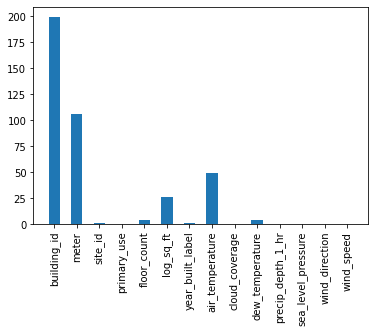

In [ ]:
plt.bar(x=list(np.arange(14)),
        height=model.feature_importances_,
        width=0.5)
plt.xticks(list(np.arange(14)), labels=feature_name, rotation=90)
plt.show()

### Observation:
- building_id , meter, air_temperature are 3 most important feature
- other features are log_sq_ft, dew_temperature, floor_count and site_id
- features which were not used are: primary_use, cloud_coverage, precip_depth_1_hr, sea_level_pressure, wind_direction, wind_speed 

# Experiment

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
import datetime

In [ ]:
class experiment():
    def __init__(self, data, root_path='./project/results.csv'):
        self.data = data.copy()
        # self.models = dict()
        # self.results = dict()
        # self.features = dict()
        self.root_path = root_path
        if os.path.exists(root_path):
            self.results = pd.read_csv(root_path)
        else:
            self.results = pd.DataFrame(columns=['experiment_name', 'description', 'model',
                                                 'result', 'features','categorical_feature',
                                                 'train_data',
                                                 'val_data'])
        self.curr_model = None

    def prepare(self, name, feature, split_month=6, description='', n=500, building_sample=None):
        if (name == self.results.experiment_name).any():
            assert False, f"experiment {name} already exists please provide different name"

        data_train = self.data[self.data.timestamp.dt.month <= split_month]
        data_test = self.data[self.data.timestamp.dt.month > split_month]

        X_pre_train = data_train[feature + ['timestamp']]
        y_pre_train = data_train['log_meter_reading']

        X_pre_test = data_test[feature + ['timestamp']]
        y_pre_test = data_test['log_meter_reading']

        #sample 100 building for our first-cut solution
        if building_sample is None:
            building_sample = np.random.choice(1449, n, replace=False)
        else:
            try:
                assert isinstance(building_sample, list), "building sample should be a list"
            except AssertionError as e:
                print(e)
                return

        X_pre_train_sampled = X_pre_train.loc[X_pre_train.building_id.isin(building_sample)]
        y_pre_train_sampled = y_pre_train.loc[X_pre_train.building_id.isin(building_sample)]

        X_pre_test_sampled = X_pre_test.loc[X_pre_test.building_id.isin(building_sample)]
        y_pre_test_sampled = y_pre_test.loc[X_pre_test.building_id.isin(building_sample)]

        return (X_pre_train_sampled, y_pre_train_sampled, X_pre_test_sampled, y_pre_test_sampled)


    def run(self, name, feature, categorical_feature, month_list, split_month=6, description='', n=500, building_sample=None):
        X_pre_train_sampled, y_pre_train_sampled, X_pre_test_sampled, y_test = self.prepare(name, feature,
                                                                                            split_month,
                                                                                            description, n,
                                                                                            building_sample)
        X_test = X_pre_test_sampled.drop(columns='timestamp')
        if not os.path.exists('model'):
            os.makedirs('model')


        for month in month_list:
            param = {'num_leaves':70, 
                    'max_depth':7, 
                    'n_estimators':500,
                    'subsample ':0.8,
                    'subsample_freq':5,
                    'colsample_bytree':0.8,
                    'reg_alpha':0.1,
                    'reg_lambda':0.1}

            X_train = X_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month <= month].drop(columns='timestamp')
            X_train = X_train[feature]
            y_train = y_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month <= month]

            X_val = X_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month > month].drop(columns='timestamp')
            X_val = X_val[feature]
            y_val = y_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month > month]

            self.curr_model = LGBMRegressor(**param)
            self.curr_model.fit(X_train, y_train,  eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='rmse',
                                feature_name= feature,
                                categorical_feature= categorical_feature,
                                callbacks=[early_stopping(10)], verbose=101)
            
            y_hat_test = self.curr_model.predict(X_test[feature])
            result = mean_squared_error(y_test, y_hat_test)
            
            model_path = os.path.join('model', f"{name}-{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}.pkl")
            pickle.dump(self.curr_model, open(model_path,'wb'))

            my_dict = {'experiment_name':name,
                       'description':description,
                       'model':model_path,
                       'result':result,
                       'features':[feature],
                       'categorical_feature':[categorical_feature],
                       'train_data':split_month,
                       'val_data':month}
            self.results = pd.concat([self.results, pd.DataFrame(my_dict)], ignore_index=True)
        self.results.to_csv(self.root_path, index=False)

    def prepare_by_day(self, name, feature, split_day=15, description='', n=500, building_sample=None):
        if (name == self.results.experiment_name).any():
            assert False, f"experiment {name} already exists please provide different name"

        data_train = self.data[self.data.timestamp.dt.day <= split_day]
        data_test = self.data[self.data.timestamp.dt.day > split_day]

        X_pre_train = data_train[feature]
        y_pre_train = data_train['log_meter_reading']

        X_pre_test = data_test[feature]
        y_pre_test = data_test['log_meter_reading']

        #sample 100 building for our first-cut solution
        if building_sample is None:
            building_sample = np.random.choice(1449, n, replace=False)
        else:
            try:
                assert isinstance(building_sample, list), "building sample should be a list"
            except AssertionError as e:
                print(e)
                return

        X_pre_train_sampled = X_pre_train.loc[X_pre_train.building_id.isin(building_sample)]
        y_pre_train_sampled = y_pre_train.loc[X_pre_train.building_id.isin(building_sample)]

        X_pre_test_sampled = X_pre_test.loc[X_pre_test.building_id.isin(building_sample)]
        y_pre_test_sampled = y_pre_test.loc[X_pre_test.building_id.isin(building_sample)]

        return (X_pre_train_sampled, y_pre_train_sampled, X_pre_test_sampled, y_pre_test_sampled)

    def run_by_day(self, name, feature, categorical_feature, split_day=6, description='', n=500, building_sample=None):
        X_train, y_train, X_val, y_val = self.prepare_by_day(name, feature,
                                                            split_day,
                                                            description, n,
                                                            building_sample)
        X_train = X_train[feature]
        X_val = X_val[feature]

        param = {'num_leaves':70, 
                'max_depth':7, 
                'n_estimators':500,
                'subsample ':0.8,
                'subsample_freq':5,
                'colsample_bytree':0.8,
                'reg_alpha':0.1,
                'reg_lambda':0.1}
                    
        self.curr_model = LGBMRegressor(**param)
        self.curr_model.fit(X_train, y_train,  eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='rmse',
                            feature_name= feature,
                            categorical_feature= categorical_feature,
                            callbacks=[early_stopping(10)], verbose=101)
            
        model_path = os.path.join('model', f"{name}-{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}.pkl")
        pickle.dump(self.curr_model, open(model_path,'wb'))

        my_dict = {'experiment_name':name,
                    'description':description,
                    'model':model_path,
                    'result':'None',
                    'features':[feature],
                    'categorical_feature':[categorical_feature],
                    'train_data':split_day,
                    'val_data':'None'}
        self.results = pd.concat([self.results, pd.DataFrame(my_dict)], ignore_index=True)
        self.results.to_csv(self.root_path, index=False)

    def get_results(self):
        return self.results

    def predict(self, model, x_list, feature):
        l = []
        for x in x_list:
            n = x.shape[0] // 4
            y = np.zeros(x.shape[0])
            for i in range(3):
                y[i*n:(i+1)*n] =  model.predict(x[feature].iloc[i*n:(i+1)*n])
            y[(i+1)*n:] =  model.predict(x[feature].iloc[(i+1)*n:])
            y_df = x[['row_id']].copy()
            y_df.loc[:, 'meter_reading'] = np.clip(np.expm1(y), 0, None)
            l.append(y_df)
        submission = pd.concat(l)
        submission = submission.sort_values(by='row_id')
        return submission

    def plot_feature_importance(self, model=None, feature=None):
        if model is not None:
            self.curr_model = model
        if self.curr_model is None:
            print("Please provide model and feature name to evaluate")
        else:
            if feature is not None:
                plt.bar(x=list(np.arange(len(feature))),
                        height=self.curr_model.feature_importances_,
                        width=0.5)
                plt.xticks(list(np.arange(len(feature))), labels=feature, rotation=90)
                plt.show()
            else:
                print("Please provide list of valid feature names")

## Iteration 1

About Experiment:
- We sampled random 500 building for our experiment
- Took first 6 month as our train data and remaining 6 month as test data
- We used time based features like dayofweek and hour
- Results:
    - train rmse: 0.7841466108731613
    - val rmse: 1.5566608880111874
    - test rmse: 3.479901
- Conclusion:
    - There is huge difference between train and test rmse
    - Clearly model is not generalizing well
    - This could be due to change meter reading distribution between train and test data
    - We can further improve performance by cleaning data

In [ ]:
expt = experiment(final_data)

In [ ]:
feature = ['building_id', 'meter', 'site_id', 'primary_use',
           'floor_count', 'log_sq_ft', 'year_built_label',
           'air_temperature', 'cloud_coverage', 'dew_temperature',
           'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
           'wind_speed', 'dayofweek', 'hour']
categorical_feature = ['building_id', 'meter', 'site_id', 'primary_use', 
                       'year_built_label', 'wind_direction', 'hour', 'dayofweek']

In [ ]:
final_data.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading',
       'log_meter_reading', 'site_id', 'primary_use', 'square_feet',
       'year_built', 'floor_count', 'log_sq_ft', 'year_built_label',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'dayofweek', 'hour'],
      dtype='object')

In [ ]:
expt.run(name='expt1', feature=feature, categorical_feature=categorical_feature,
         month_list=[2,4], split_month=6, description='first_cut_solution')

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'site_id', 'wind_direction', 'year_built_label']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[11]	training's l2: 1.32161	training's rmse: 1.14961	valid_1's l2: 2.91635	valid_1's rmse: 1.70773


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'site_id', 'wind_direction', 'year_built_label']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.614886	training's rmse: 0.784147	valid_1's l2: 2.42319	valid_1's rmse: 1.55666


In [ ]:
df = expt.get_results()
df.head()

,experiment_name,description,model,result,features,categorical_feature,train_data,val_data
0,expt1,first_cut_solution,LGBMRegressor(),4.015130,"[building_id, meter, site_id, primary_use, flo...","[building_id, meter, site_id, primary_use, yea...",6,2
1,expt1,first_cut_solution,LGBMRegressor(),3.479901,"[building_id, meter, site_id, primary_use, flo...","[building_id, meter, site_id, primary_use, yea...",6,4


In [ ]:
df.loc[0, 'model'].best_score_

defaultdict(dict,
            {'training': {'l2': 1.3216050179969252,
              'rmse': 1.1496108115344623},
             'valid_1': {'l2': 2.9163523442424504,
              'rmse': 1.7077331009974746}})

In [ ]:
df.loc[1, 'model'].best_score_

defaultdict(dict,
            {'training': {'l2': 0.614885907343865, 'rmse': 0.7841466108731613},
             'valid_1': {'l2': 2.4231931202637784,
              'rmse': 1.5566608880111874}})

In [ ]:
X = final_data[['meter_reading', 'timestamp', 'site_id', 'building_id', 'meter']].set_index('timestamp')
Y_train = X.loc[X.index.month <= 6, 'meter_reading']
Y_test = X.loc[X.index.month > 6, 'meter_reading']

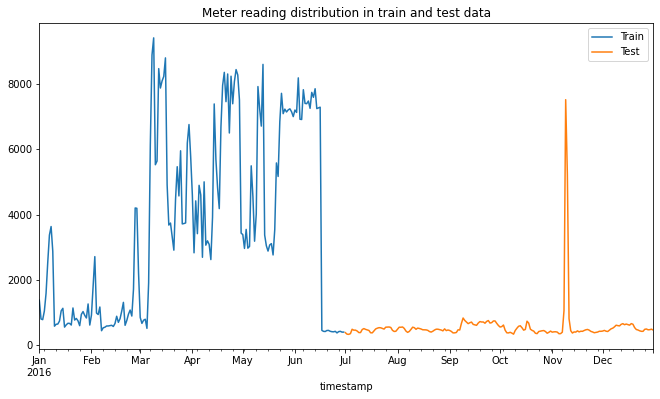

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(11,6))
Y_train.resample('D').mean().plot(ax=axs, label='Train')
Y_test.resample('D').mean().plot(ax=axs, label='Test')
axs.legend()
axs.set_title("Meter reading distribution in train and test data")
plt.show()

In [ ]:
# X = final_data[['meter_reading', 'timestamp', 'site_id', 'building_id', 'meter']].set_index('timestamp')
Y_train = X.loc[(X.index.month <= 6) & (X.building_id != 1099), 'meter_reading']
Y_test = X.loc[(X.index.month > 6) & (X.building_id != 1099), 'meter_reading']

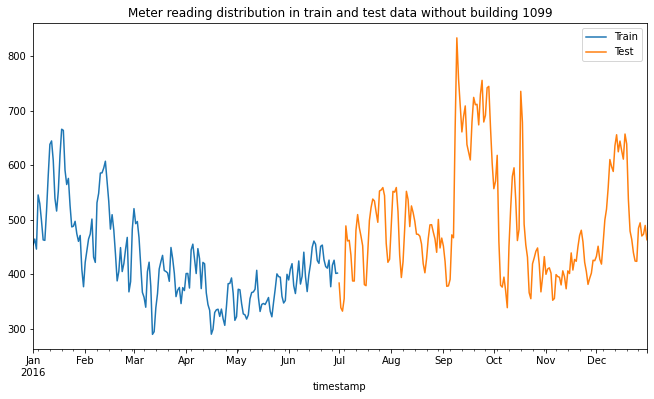

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(11,6))
Y_train.resample('D').mean().plot(ax=axs, label='Train')
Y_test.resample('D').mean().plot(ax=axs, label='Test')
axs.legend()
axs.set_title("Meter reading distribution in train and test data without building 1099")
plt.show()

## Iteration 2

About Experiments:
- We increase our train data from 4 to 6 month (January - June)
- We would use 7-8 as our validation month (July and August)
- Remaining 9,10,11,12 will be used as test data (September - December)


In [ ]:
expt = experiment(final_data)

In [ ]:
feature = ['building_id', 'meter', 'site_id', 'primary_use',
           'floor_count', 'log_sq_ft', 'year_built_label',
           'air_temperature', 'cloud_coverage', 'dew_temperature',
           'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
           'wind_speed', 'dayofweek', 'hour']
categorical_feature = ['building_id', 'meter', 'site_id', 'primary_use', 
                       'year_built_label', 'wind_direction', 'hour', 'dayofweek']

In [ ]:
expt.run(name='expt2', feature=feature, categorical_feature=categorical_feature,
         month_list=[5,7], split_month=8, description='train data month increased to 6')

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'site_id', 'wind_direction', 'year_built_label']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.861604	training's l2: 0.742361	valid_1's rmse: 1.47934	valid_1's l2: 2.18844


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'site_id', 'wind_direction', 'year_built_label']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.918674	training's l2: 0.843962	valid_1's rmse: 1.03205	valid_1's l2: 1.06513


In [ ]:
expt.get_results()

,experiment_name,description,model,result,features,categorical_feature,train_data,val_data
0,expt1,first_cut_solution,LGBMRegressor(),4.015130,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",6,2
1,expt1,first_cut_solution,LGBMRegressor(),3.479901,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",6,4
2,expt2,train data month increased to 6,LGBMRegressor(),2.444116,"[building_id, meter, site_id, primary_use, flo...","[building_id, meter, site_id, primary_use, yea...",8,5
3,expt2,train data month increased to 6,LGBMRegressor(),1.997163,"[building_id, meter, site_id, primary_use, flo...","[building_id, meter, site_id, primary_use, yea...",8,7


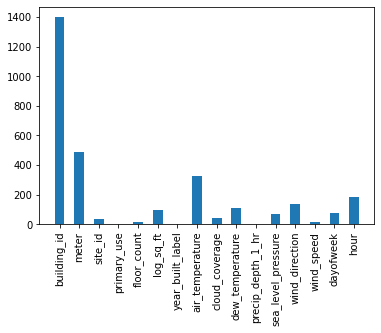

In [ ]:
expt.plot_feature_importance(model=expt.get_results()['model'][2], feature=feature)

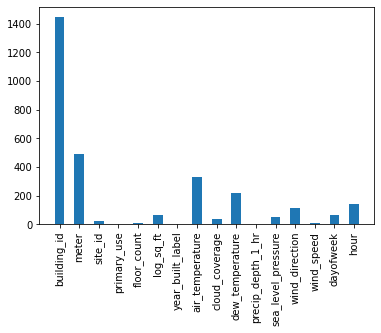

In [ ]:
expt.plot_feature_importance(feature=feature)

## Iteration 3:

About Experiments:
- Remove unused columns like primary_use, year_built_label, precip_depth_1_hr
- Also we would combine floor_count and square_feet column

In [ ]:
feature = ['building_id', 'meter', 'site_id', 
           'floor_sq_ft',
           'air_temperature', 'cloud_coverage', 'dew_temperature',
           'sea_level_pressure', 'wind_direction',
           'wind_speed', 'dayofweek', 'hour']
categorical_feature = ['building_id', 'meter', 'site_id', 
                       'wind_direction', 'hour', 'dayofweek']

expt.run(name='expt3', feature=feature, categorical_feature=categorical_feature,
         month_list=[5,7], split_month=8, description='remove unused features')

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'site_id', 'wind_direction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.858297	training's l2: 0.736673	valid_1's rmse: 1.50249	valid_1's l2: 2.25747


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'site_id', 'wind_direction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.913326	training's l2: 0.834164	valid_1's rmse: 0.933835	valid_1's l2: 0.872048


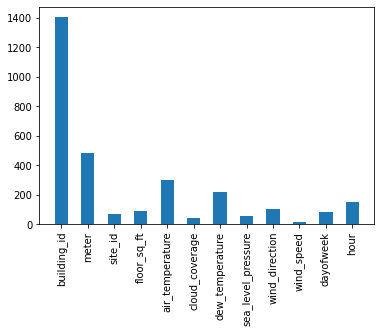

In [ ]:
expt.plot_feature_importance(feature=feature)

In [ ]:
expt.get_results()

,experiment_name,description,model,result,features,categorical_feature,train_data,val_data
0,expt1,first_cut_solution,LGBMRegressor(),4.015130,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",6,2
1,expt1,first_cut_solution,LGBMRegressor(),3.479901,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",6,4
2,expt2,train data month increased to 6,LGBMRegressor(),2.444116,"[building_id, meter, site_id, primary_use, flo...","[building_id, meter, site_id, primary_use, yea...",8,5
3,expt2,train data month increased to 6,LGBMRegressor(),1.997163,"[building_id, meter, site_id, primary_use, flo...","[building_id, meter, site_id, primary_use, yea...",8,7
4,expt3,remove unused features,LGBMRegressor(),2.689460,"[building_id, meter, site_id, floor_sq_ft, air...","[building_id, meter, site_id, wind_direction, ...",8,5
5,expt3,remove unused features,LGBMRegressor(),2.171603,"[building_id, meter, site_id, floor_sq_ft, air...","[building_id, meter, site_id, wind_direction, ...",8,7


## Iteration 4:

About Experiments:
- Remove building id 1099

In [ ]:
expt = experiment(final_data)

In [ ]:
expt.data = expt.data[expt.data['building_id'] != 1099]

In [ ]:
feature = ['building_id', 'meter', 'site_id', 
           'floor_sq_ft',
           'air_temperature', 'cloud_coverage', 'dew_temperature',
           'sea_level_pressure', 'wind_direction',
           'wind_speed', 'dayofweek', 'hour']
categorical_feature = ['building_id', 'meter', 'site_id', 
                       'wind_direction', 'hour', 'dayofweek']

expt.run(name='expt4', feature=feature, categorical_feature=categorical_feature,
         month_list=[5,7], split_month=8, description='Without 1099')

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'site_id', 'wind_direction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.692736	training's rmse: 0.832308	valid_1's l2: 2.08689	valid_1's rmse: 1.44461


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'site_id', 'wind_direction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.804011	training's rmse: 0.896667	valid_1's l2: 0.952906	valid_1's rmse: 0.976169


In [ ]:
expt.get_results()

,experiment_name,description,model,result,features,categorical_feature,train_data,val_data
0,expt1,first_cut_solution,LGBMRegressor(),4.015130,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",6,2
1,expt1,first_cut_solution,LGBMRegressor(),3.479901,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",6,4
2,expt2,train data month increased to 6,LGBMRegressor(),2.444116,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",8,5
3,expt2,train data month increased to 6,LGBMRegressor(),1.997163,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",8,7
4,expt3,remove unused features,LGBMRegressor(),2.689460,"['building_id', 'meter', 'site_id', 'floor_sq_...","['building_id', 'meter', 'site_id', 'wind_dire...",8,5
5,expt3,remove unused features,LGBMRegressor(),2.171603,"['building_id', 'meter', 'site_id', 'floor_sq_...","['building_id', 'meter', 'site_id', 'wind_dire...",8,7
6,expt4,Without 1099,LGBMRegressor(),2.333531,"[building_id, meter, site_id, floor_sq_ft, air...","[building_id, meter, site_id, wind_direction, ...",8,5
7,expt4,Without 1099,LGBMRegressor(),1.942578,"[building_id, meter, site_id, floor_sq_ft, air...","[building_id, meter, site_id, wind_direction, ...",8,7


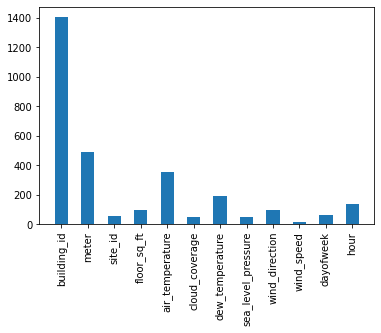

In [ ]:
expt.plot_feature_importance(feature=feature)

## Iteration 5:

In [ ]:
final_data = pickle.load(open(os.path.join('data', 'final_data', 'final_data.pkl'), 'rb'))

In [ ]:
final_data.dropna(inplace=True)

In [ ]:
final_data['log_meter_reading'] = np.log1p(final_data['meter_reading'])

In [ ]:
expt = experiment(final_data)

In [ ]:
feature = ['air_temperature', 'cloud_coverage',
            'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
            'wind_speed', 'air_temperature_max_past_18',
            'air_temperature_min_past_18', 'air_temperature_mean_past_18',
            'air_temperature_median_past_18', 'air_temperature_std_past_18',
            'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
            'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
            'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
            'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
            'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
            'precip_depth_1_hr_max_past_18', 'precip_depth_1_hr_min_past_18',
            'precip_depth_1_hr_mean_past_18', 'precip_depth_1_hr_median_past_18',
            'precip_depth_1_hr_std_past_18',
            'sin_hour', 'sin_month', 'sin_wind_direction',
           'meter', 'building_id', 'quarter',
            'site_id', 'primary_use', 'floor_count',
            'log_sq_ft', 'year_built_label', 'wind_direction',
            'month', 'dayofweek', 'hour']
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use', 'floor_count',
                       'log_sq_ft', 'year_built_label', 'wind_direction',
                       'month', 'dayofweek', 'hour']

expt.run(name='expt5', feature=feature, categorical_feature=categorical_feature,
         month_list=[5,7], split_month=8, description='will all preprocessing')

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'floor_count', 'hour', 'log_sq_ft', 'meter', 'month', 'primary_use', 'quarter', 'site_id', 'wind_direction', 'year_built_label']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.662079	training's l2: 0.438349	valid_1's rmse: 0.942985	valid_1's l2: 0.88922


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'floor_count', 'hour', 'log_sq_ft', 'meter', 'month', 'primary_use', 'quarter', 'site_id', 'wind_direction', 'year_built_label']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.693571	training's l2: 0.48104	valid_1's rmse: 0.836337	valid_1's l2: 0.699459


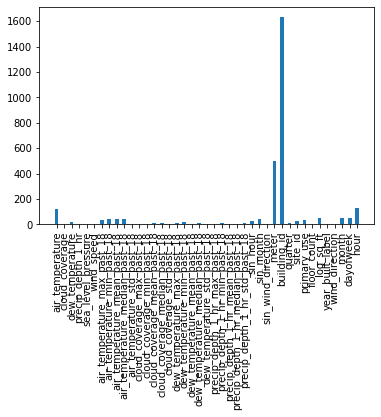

In [ ]:
expt.plot_feature_importance(feature=feature)

In [ ]:
expt.get_results()

,experiment_name,description,model,result,features,categorical_feature,train_data,val_data
0,expt1,first_cut_solution,LGBMRegressor(),4.015130,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",6,2
1,expt1,first_cut_solution,LGBMRegressor(),3.479901,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",6,4
2,expt2,train data month increased to 6,LGBMRegressor(),2.444116,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",8,5
3,expt2,train data month increased to 6,LGBMRegressor(),1.997163,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",8,7
4,expt3,remove unused features,LGBMRegressor(),2.689460,"['building_id', 'meter', 'site_id', 'floor_sq_...","['building_id', 'meter', 'site_id', 'wind_dire...",8,5
5,expt3,remove unused features,LGBMRegressor(),2.171603,"['building_id', 'meter', 'site_id', 'floor_sq_...","['building_id', 'meter', 'site_id', 'wind_dire...",8,7
6,expt4,Without 1099,LGBMRegressor(),2.333531,"['building_id', 'meter', 'site_id', 'floor_sq_...","['building_id', 'meter', 'site_id', 'wind_dire...",8,5
7,expt4,Without 1099,LGBMRegressor(),1.942578,"['building_id', 'meter', 'site_id', 'floor_sq_...","['building_id', 'meter', 'site_id', 'wind_dire...",8,7
8,expt5,will all preprocessing,model/expt5-20220822-065159.pkl,0.805420,"[air_temperature, cloud_coverage, dew_temperat...","[meter, building_id, quarter, site_id, primary...",8,5
9,expt5,will all preprocessing,model/expt5-20220822-065327.pkl,0.752073,"[air_temperature, cloud_coverage, dew_temperat...","[meter, building_id, quarter, site_id, primary...",8,7


## Iteration 6:

In [ ]:
from sklearn.model_selection import train_test_split
building_sample_1, building_sample_2 = train_test_split(p_building_metadata_df[['site_id', 'building_id']],
                                     test_size=0.5, stratify=p_building_metadata_df['site_id'])
building_sample_1 = building_sample_1['building_id'].tolist()
building_sample_2 = building_sample_2['building_id'].tolist()

In [ ]:
expt = experiment(final_data)

feature = ['air_temperature', 
            'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
            'air_temperature_max_past_18',
            'air_temperature_min_past_18', 'air_temperature_mean_past_18',
            'air_temperature_median_past_18', 'air_temperature_std_past_18',
            'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
            'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
            'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
            'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
            'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
            'sin_hour', 'sin_month', 
            'meter', 'building_id', 'quarter',
            'site_id', 'primary_use', 'floor_count',
            'log_sq_ft', 
            'month', 'dayofweek', 'hour']
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use', 'floor_count',
                       'log_sq_ft',
                       'month', 'dayofweek', 'hour']

expt.run(name='expt6', feature=feature, categorical_feature=categorical_feature,
         month_list=[5,7], split_month=8, description='50% building', n=500, building_sample=building_sample_1)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'floor_count', 'hour', 'log_sq_ft', 'meter', 'month', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.528448	training's rmse: 0.726944	valid_1's l2: 1.01132	valid_1's rmse: 1.00565


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'floor_count', 'hour', 'log_sq_ft', 'meter', 'month', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.563395	training's rmse: 0.750597	valid_1's l2: 0.755731	valid_1's rmse: 0.869328


In [ ]:
expt.run(name='expt7', feature=feature, categorical_feature=categorical_feature,
         month_list=[5,7], split_month=8, description='remaining 50% building', n=500, building_sample=building_sample_2)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'floor_count', 'hour', 'log_sq_ft', 'meter', 'month', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.499065	training's rmse: 0.706445	valid_1's l2: 0.850403	valid_1's rmse: 0.922173


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'floor_count', 'hour', 'log_sq_ft', 'meter', 'month', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.526129	training's rmse: 0.725348	valid_1's l2: 0.66116	valid_1's rmse: 0.813117


In [ ]:
expt.get_results()

,experiment_name,description,model,result,features,categorical_feature,train_data,val_data
0,expt1,first_cut_solution,LGBMRegressor(),4.015130,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",6,2
1,expt1,first_cut_solution,LGBMRegressor(),3.479901,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",6,4
2,expt2,train data month increased to 6,LGBMRegressor(),2.444116,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",8,5
3,expt2,train data month increased to 6,LGBMRegressor(),1.997163,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",8,7
4,expt3,remove unused features,LGBMRegressor(),2.689460,"['building_id', 'meter', 'site_id', 'floor_sq_...","['building_id', 'meter', 'site_id', 'wind_dire...",8,5
5,expt3,remove unused features,LGBMRegressor(),2.171603,"['building_id', 'meter', 'site_id', 'floor_sq_...","['building_id', 'meter', 'site_id', 'wind_dire...",8,7
6,expt4,Without 1099,LGBMRegressor(),2.333531,"['building_id', 'meter', 'site_id', 'floor_sq_...","['building_id', 'meter', 'site_id', 'wind_dire...",8,5
7,expt4,Without 1099,LGBMRegressor(),1.942578,"['building_id', 'meter', 'site_id', 'floor_sq_...","['building_id', 'meter', 'site_id', 'wind_dire...",8,7
8,expt5,will all preprocessing,model/expt5-20220822-065159.pkl,0.805420,"['air_temperature', 'cloud_coverage', 'dew_tem...","['meter', 'building_id', 'quarter', 'site_id',...",8,5
9,expt5,will all preprocessing,model/expt5-20220822-065327.pkl,0.752073,"['air_temperature', 'cloud_coverage', 'dew_tem...","['meter', 'building_id', 'quarter', 'site_id',...",8,7


In [ ]:
pickle.dump(building_sample_1, open(os.path.join('model', 'building_sample_1.pkl'), 'wb'))
pickle.dump(building_sample_2, open(os.path.join('model', 'building_sample_2.pkl'), 'wb'))

In [ ]:
test_data_2017 = pickle.load(open(os.path.join('data', 'final_data', 'test_data_2017.pkl'), 'rb'))
test_data_2018 = pickle.load(open(os.path.join('data', 'final_data', 'test_data_2018.pkl'), 'rb'))

In [ ]:
model_1 = pickle.load(open(os.path.join('model', 'expt6-20220822-075614.pkl'), 'rb'))
model_2 = pickle.load(open(os.path.join('model', 'expt7-20220822-075952.pkl'), 'rb'))

In [ ]:
feature = ['air_temperature', 
            'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
            'air_temperature_max_past_18',
            'air_temperature_min_past_18', 'air_temperature_mean_past_18',
            'air_temperature_median_past_18', 'air_temperature_std_past_18',
            'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
            'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
            'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
            'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
            'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
            'sin_hour', 'sin_month', 
            'meter', 'building_id', 'quarter',
            'site_id', 'primary_use', 'floor_count',
            'log_sq_ft', 
            'month', 'dayofweek', 'hour']
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use', 'floor_count',
                       'log_sq_ft',
                       'month', 'dayofweek', 'hour']

In [ ]:
building_sample_1 = pickle.load(open(os.path.join('model', 'building_sample_1.pkl'), 'rb'))
building_sample_2 = pickle.load(open(os.path.join('model', 'building_sample_2.pkl'), 'rb'))

In [ ]:
del test_df

In [ ]:
test_data_2017_sample_1 = test_data_2017[test_data_2017.building_id.isin(building_sample_1)]
test_data_2017_sample_2 = test_data_2017[test_data_2017.building_id.isin(building_sample_2)]
del test_data_2017
test_data_2018_sample_1 = test_data_2018[test_data_2018.building_id.isin(building_sample_1)]
test_data_2018_sample_2 = test_data_2018[test_data_2018.building_id.isin(building_sample_2)]
del test_data_2018

In [ ]:
n = test_data_2017_sample_1.shape[0] // 4

In [ ]:
y_2017_sample_1 = np.zeros(test_data_2017_sample_1.shape[0])
for i in range(3):
    y_2017_sample_1[i*n:(i+1)*n] =  model_1.predict(test_data_2017_sample_1[feature].iloc[i*n:(i+1)*n])
y_2017_sample_1[(i+1)*n:] =  model_1.predict(test_data_2017_sample_1[feature].iloc[(i+1)*n:])

dtype('float64')

In [ ]:
y_2017_sample_2 = np.zeros(test_data_2017_sample_2.shape[0])
for i in range(3):
    y_2017_sample_2[i*n:(i+1)*n] =  model_2.predict(test_data_2017_sample_2[feature].iloc[i*n:(i+1)*n])
y_2017_sample_2[(i+1)*n:] =  model_2.predict(test_data_2017_sample_2[feature].iloc[(i+1)*n:])

In [ ]:
y_2018_sample_1 = np.zeros(test_data_2018_sample_1.shape[0])
for i in range(3):
    y_2018_sample_1[i*n:(i+1)*n] =  model_1.predict(test_data_2018_sample_1[feature].iloc[i*n:(i+1)*n])
y_2018_sample_1[(i+1)*n:] =  model_1.predict(test_data_2018_sample_1[feature].iloc[(i+1)*n:])

In [ ]:
y_2018_sample_2 = np.zeros(test_data_2018_sample_2.shape[0])
for i in range(3):
    y_2018_sample_2[i*n:(i+1)*n] = model_2.predict(test_data_2018_sample_2[feature].iloc[i*n:(i+1)*n])
y_2018_sample_2[(i+1)*n:] = model_2.predict(test_data_2018_sample_2[feature].iloc[(i+1)*n:])

In [ ]:
np.vstack([test_data_2017_sample_1['row_id'].values, y_2017_sample_1])

array([[0.00000000e+00, 5.00000000e+00, 6.00000000e+00, ...,
        4.16968440e+07, 4.16968450e+07, 4.16968460e+07],
       [3.97301257e+00, 3.97301257e+00, 4.24679057e+00, ...,
        5.31842107e+00, 2.46474272e+00, 5.35678280e+00]])

In [ ]:
y_hat_2017_sample_1 = test_data_2017_sample_1[['row_id']].copy()
y_hat_2017_sample_1.loc[:, 'meter_reading'] = y_2017_sample_1

y_hat_2017_sample_2 = test_data_2017_sample_2[['row_id']].copy()
y_hat_2017_sample_2.loc[:, 'meter_reading'] = y_2017_sample_2

y_hat_2018_sample_1 = test_data_2018_sample_1[['row_id']].copy()
y_hat_2018_sample_1.loc[:, 'meter_reading'] = y_2018_sample_1

y_hat_2018_sample_2 = test_data_2018_sample_2[['row_id']].copy()
y_hat_2018_sample_2.loc[:, 'meter_reading'] = y_2018_sample_2

In [ ]:
y_hat_2017_sample_1.head()

,row_id,meter_reading
0,0,3.973013
5,5,3.973013
6,6,4.246791
9,9,5.317525
10,10,3.738812


In [ ]:
submission = pd.concat([y_hat_2017_sample_1, y_hat_2017_sample_2, y_hat_2018_sample_1, y_hat_2018_sample_2])
submission.head()

,row_id,meter_reading
0,0,3.973013
5,5,3.973013
6,6,4.246791
9,9,5.317525
10,10,3.738812


In [ ]:
submission = submission.sort_values(by=['row_id'])
submission.head(11)

,row_id,meter_reading
0,0,3.973013
1,1,4.401169
2,2,3.930256
3,3,5.893100
4,4,5.625409
5,5,3.973013
6,6,4.246791
7,7,6.160016
8,8,6.643319
9,9,5.317525


In [ ]:
submission.loc[:, 'meter_reading'] = np.clip(np.expm1(submission['meter_reading']), 0, None)

In [ ]:
submission.head(11)

,row_id,meter_reading
0,0,52.144391
1,1,80.546145
2,2,49.920020
3,3,361.527540
4,4,276.385622
5,5,52.144391
6,6,68.880775
7,7,472.435504
8,8,766.638901
9,9,202.878755


In [ ]:
submission.to_csv("submission.csv", index=False, float_format="%.4f")

## Iteration 7:

In [ ]:
building_sample_1 = pickle.load(open(os.path.join('model', 'building_sample_1.pkl'), 'rb'))
building_sample_2 = pickle.load(open(os.path.join('model', 'building_sample_2.pkl'), 'rb'))

In [ ]:
final_data = pickle.load(open(os.path.join('data', 'final_data', 'final_data.pkl'), 'rb'))

In [ ]:
final_data = final_data.assign(log_meter_reading = np.log1p(final_data['meter_reading']))

In [ ]:
final_data.isna().sum().sum()

0

In [ ]:
expt = experiment(final_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'month', 'dayofweek', 'hour']
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use', 'floor_count',
                       'log_sq_ft',
                       'month', 'dayofweek', 'hour']

expt.run(name='expt8', feature=feature, categorical_feature=categorical_feature,
         month_list=[5,7], split_month=8, description='50% building', n=500, building_sample=building_sample_1)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'floor_count', 'hour', 'log_sq_ft', 'meter', 'month', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.745714	training's l2: 0.556089	valid_1's rmse: 1.12565	valid_1's l2: 1.2671


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'floor_count', 'hour', 'log_sq_ft', 'meter', 'month', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.792953	training's l2: 0.628774	valid_1's rmse: 1.0328	valid_1's l2: 1.06667


In [ ]:
expt.run(name='expt9', feature=feature, categorical_feature=categorical_feature,
         month_list=[8,9], split_month=10, description='50% building', n=500, building_sample=building_sample_1)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'floor_count', 'hour', 'log_sq_ft', 'meter', 'month', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.802119	training's l2: 0.643396	valid_1's rmse: 1.06778	valid_1's l2: 1.14014


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'floor_count', 'hour', 'log_sq_ft', 'meter', 'month', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.810085	training's l2: 0.656238	valid_1's rmse: 1.18225	valid_1's l2: 1.39772


In [ ]:
del final_data

In [ ]:
test_data_2017 = pickle.load(open(os.path.join('data', 'final_data', 'test_data_2017.pkl'), 'rb'))
test_data_2018 = pickle.load(open(os.path.join('data', 'final_data', 'test_data_2018.pkl'), 'rb'))

In [ ]:
test_data_2017_sample_1 = test_data_2017[test_data_2017.building_id.isin(building_sample_1)]
test_data_2017_sample_2 = test_data_2017[test_data_2017.building_id.isin(building_sample_2)]
del test_data_2017
test_data_2018_sample_1 = test_data_2018[test_data_2018.building_id.isin(building_sample_1)]
test_data_2018_sample_2 = test_data_2018[test_data_2018.building_id.isin(building_sample_2)]
del test_data_2018

In [ ]:
model = pickle.load(open('model/expt9-20220822-131027.pkl', 'rb'))

In [ ]:
submission = expt.predict(model,[test_data_2017_sample_1, test_data_2017_sample_2, test_data_2018_sample_1, test_data_2018_sample_2],
                          feature)

In [ ]:
submission.head()

,row_id,meter_reading
0,0,209.385144
1,1,11.979958
2,2,37.481096
3,3,101.845586
4,4,244.932994


In [ ]:
submission.to_csv("submission.csv", index=False, float_format="%.4f")

In [ ]:
expt.get_results()

In [ ]:
test_df = pickle.load(open('data/input_data/test_df.pkl', 'rb'))

In [ ]:
del test_data_2017_sample_1, test_data_2017_sample_2, test_data_2018_sample_1, test_data_2018_sample_2

In [ ]:
test_df = test_df.merge(submission, on='row_id', how='left')

In [ ]:
test_df.head()

,row_id,building_id,meter,timestamp,meter_reading
0,0,0,0,2017-01-01,209.385144
1,1,1,0,2017-01-01,11.979958
2,2,2,0,2017-01-01,37.481096
3,3,3,0,2017-01-01,101.845586
4,4,4,0,2017-01-01,244.932994


In [ ]:
final_data = pickle.load(open(os.path.join('data', 'final_data', 'final_data.pkl'), 'rb'))

In [ ]:
train_data = final_data[['timestamp', 'meter_reading', 'building_id', 'meter']].copy()

In [ ]:
train_data =  train_data.assign(hour=train_data.timestamp.dt.hour,
                            dayofweek=train_data.timestamp.dt.dayofweek,
                            month=train_data.timestamp.dt.month)\
                            .astype({'hour':np.int8,
                                    'dayofweek':np.int8,
                                    'month':np.int8})
test_df =  test_df.assign(hour=test_df.timestamp.dt.hour,
                            dayofweek=test_df.timestamp.dt.dayofweek,
                            month=test_df.timestamp.dt.month)\
                            .astype({'hour':np.int8,
                                    'dayofweek':np.int8,
                                    'month':np.int8})

In [ ]:
test_condition_1 = (test_df.building_id==2) & (test_df.meter==0) & (test_df.timestamp.dt.year==2017)
test_condition_2 = (test_df.building_id==2) & (test_df.meter==0) & (test_df.timestamp.dt.year==2018)
train_condition = (train_data.building_id==2) & (train_data.meter==0)

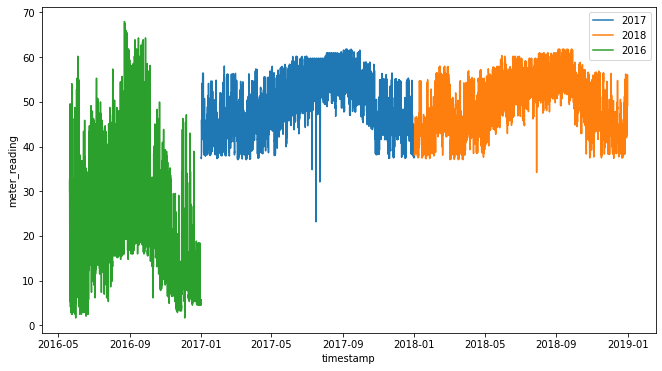

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(11,6), sharex=True)
sns.lineplot(data=test_df[test_condition_1], x='timestamp', y='meter_reading', label=2017, ax=axs)
sns.lineplot(data=test_df[test_condition_2], x='timestamp', y='meter_reading', label=2018, ax=axs)
sns.lineplot(data=train_data[train_condition], x='timestamp', y='meter_reading', label=2016, ax=axs)
axs.legend()
plt.show()

In [ ]:
test_df[test_condition_2]

,row_id,building_id,meter,timestamp,meter_reading
0,0,0,0,2017-01-01 00:00:00,209.385144
129,129,0,0,2017-01-01 01:00:00,210.463447
258,258,0,0,2017-01-01 02:00:00,210.301246
387,387,0,0,2017-01-01 03:00:00,210.102699
516,516,0,0,2017-01-01 04:00:00,209.795026
...,...,...,...,...,...
1129395,1129395,0,0,2017-12-31 19:00:00,204.206495
1129524,1129524,0,0,2017-12-31 20:00:00,204.206495
1129653,1129653,0,0,2017-12-31 21:00:00,204.206495
1129782,1129782,0,0,2017-12-31 22:00:00,206.113301


## Iteration 8:

In [ ]:
building_sample_1 = pickle.load(open(os.path.join('model', 'building_sample_1.pkl'), 'rb'))
building_sample_2 = pickle.load(open(os.path.join('model', 'building_sample_2.pkl'), 'rb'))
final_data = pickle.load(open(os.path.join('data', 'final_data', 'final_data.pkl'), 'rb'))

In [ ]:
final_data = final_data.assign(log_meter_reading=np.log1p(final_data['meter_reading']))

In [ ]:
# expt = experiment(final_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour']
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']

expt.run(name='expt10', feature=feature, categorical_feature=categorical_feature,
         month_list=[5,7], split_month=8, description='50% building', n=500, building_sample=building_sample_1)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'floor_count', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.562987	training's rmse: 0.750325	valid_1's l2: 1.24895	valid_1's rmse: 1.11756


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'floor_count', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.629594	training's rmse: 0.79347	valid_1's l2: 0.996706	valid_1's rmse: 0.998352


In [ ]:
data = final_data[final_data.timestamp.dt.month<=6].groupby(['meter', 'hour']).agg(mean_hour = ('log_meter_reading', 'mean'))
data = data.reset_index().astype({'meter':np.int8,
                                  'hour':np.int8})

In [ ]:
final_data = final_data.merge(data, on=['meter', 'hour'], how='left')

In [ ]:
data = final_data[final_data.timestamp.dt.month<=6].groupby(['meter', 'dayofweek']).agg(mean_dayofweek = ('log_meter_reading', 'mean'))
data = data.reset_index().astype({'meter':np.int8,
                                  'dayofweek':np.int8})

In [ ]:
final_data = final_data.merge(data, on=['meter', 'dayofweek'], how='left')

In [ ]:
final_data.isna().sum().sum()

0

In [ ]:
expt = experiment(final_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour', 'mean_hour', 'mean_dayofweek']
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']

expt.run(name='expt11', feature=feature, categorical_feature=categorical_feature,
         month_list=[6], split_month=8, description='with mean reading added', n=500, building_sample=building_sample_1)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.772434	training's l2: 0.596655	valid_1's rmse: 1.06621	valid_1's l2: 1.1368


In [ ]:
expt.get_results()

,experiment_name,description,model,result,features,categorical_feature,train_data,val_data
0,expt1,first_cut_solution,LGBMRegressor(),4.015130,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",6,2
1,expt1,first_cut_solution,LGBMRegressor(),3.479901,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",6,4
2,expt2,train data month increased to 6,LGBMRegressor(),2.444116,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",8,5
3,expt2,train data month increased to 6,LGBMRegressor(),1.997163,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",8,7
4,expt3,remove unused features,LGBMRegressor(),2.689460,"['building_id', 'meter', 'site_id', 'floor_sq_...","['building_id', 'meter', 'site_id', 'wind_dire...",8,5
5,expt3,remove unused features,LGBMRegressor(),2.171603,"['building_id', 'meter', 'site_id', 'floor_sq_...","['building_id', 'meter', 'site_id', 'wind_dire...",8,7
6,expt4,Without 1099,LGBMRegressor(),2.333531,"['building_id', 'meter', 'site_id', 'floor_sq_...","['building_id', 'meter', 'site_id', 'wind_dire...",8,5
7,expt4,Without 1099,LGBMRegressor(),1.942578,"['building_id', 'meter', 'site_id', 'floor_sq_...","['building_id', 'meter', 'site_id', 'wind_dire...",8,7
8,expt5,will all preprocessing,model/expt5-20220822-065159.pkl,0.805420,"['air_temperature', 'cloud_coverage', 'dew_tem...","['meter', 'building_id', 'quarter', 'site_id',...",8,5
9,expt5,will all preprocessing,model/expt5-20220822-065327.pkl,0.752073,"['air_temperature', 'cloud_coverage', 'dew_tem...","['meter', 'building_id', 'quarter', 'site_id',...",8,7


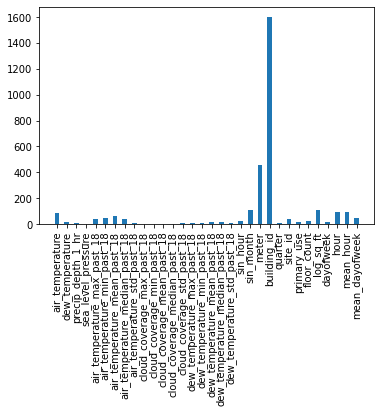

In [ ]:
expt.plot_feature_importance(feature=feature)

## Iteration 9:

In [ ]:
expt = experiment(final_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour', 'mean_hour', 'mean_dayofweek']
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']

expt.run(name='expt12', feature=feature, categorical_feature=categorical_feature,
         month_list=[6], split_month=8, description='with mean reading added', n=500, building_sample=building_sample_1)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
[101]	training's rmse: 0.773473	training's l2: 0.598261	valid_1's rmse: 1.10233	valid_1's l2: 1.21513
[202]	training's rmse: 0.700807	training's l2: 0.491131	valid_1's rmse: 1.07036	valid_1's l2: 1.14567
[303]	training's rmse: 0.664702	training's l2: 0.441829	valid_1's rmse: 1.05934	valid_1's l2: 1.1222
Early stopping, best iteration is:
[352]	training's rmse: 0.651109	training's l2: 0.423943	valid_1's rmse: 1.05471	valid_1's l2: 1.11241


In [ ]:
expt.get_results().iloc[-5:]

,experiment_name,description,model,result,features,categorical_feature,train_data,val_data
17,expt9,50% building,model/expt9-20220822-131027.pkl,1.021377,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",10,9
18,expt10,50% building,model/expt10-20220822-142457.pkl,1.443476,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",8,5
19,expt10,50% building,model/expt10-20220822-142633.pkl,1.193770,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",8,7
20,expt11,with mean reading added,model/expt11-20220822-145334.pkl,1.309013,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",8,6
21,expt12,with mean reading added,model/expt12-20220822-151305.pkl,1.444089,"[air_temperature, dew_temperature, precip_dept...","[meter, building_id, quarter, site_id, primary...",8,6


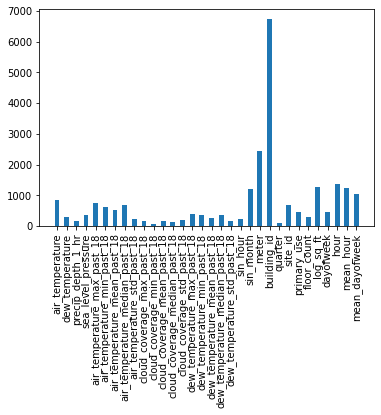

In [ ]:
expt.plot_feature_importance(feature=feature)

In [ ]:
# expt = experiment(final_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour', 'mean_hour', 'mean_dayofweek']
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']

expt.run(name='expt13', feature=feature, categorical_feature=categorical_feature,
         month_list=[6], split_month=8, description='with mean reading added sample buiding 2', n=500, building_sample=building_sample_2)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
[101]	training's rmse: 0.732779	training's l2: 0.536964	valid_1's rmse: 1.00752	valid_1's l2: 1.0151
[202]	training's rmse: 0.659996	training's l2: 0.435595	valid_1's rmse: 0.974195	valid_1's l2: 0.949056
Early stopping, best iteration is:
[201]	training's rmse: 0.660501	training's l2: 0.436262	valid_1's rmse: 0.972414	valid_1's l2: 0.945588


In [ ]:
expt.get_results().iloc[-5:]

,experiment_name,description,model,result,features,categorical_feature,train_data,val_data
18,expt10,50% building,model/expt10-20220822-142457.pkl,1.443476,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",8,5
19,expt10,50% building,model/expt10-20220822-142633.pkl,1.193770,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",8,7
20,expt11,with mean reading added,model/expt11-20220822-145334.pkl,1.309013,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",8,6
21,expt12,with mean reading added,model/expt12-20220822-151305.pkl,1.444089,"[air_temperature, dew_temperature, precip_dept...","[meter, building_id, quarter, site_id, primary...",8,6
22,expt13,with mean reading added sample buiding 2,model/expt13-20220822-152148.pkl,1.358963,"[air_temperature, dew_temperature, precip_dept...","[meter, building_id, quarter, site_id, primary...",8,6


In [ ]:
meter_0_data = final_data[final_data.meter==0]

expt = experiment(meter_0_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour', 'mean_hour', 'mean_dayofweek']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']

expt.run(name='expt14', feature=feature, categorical_feature=categorical_feature,
         month_list=[6], split_month=8, description='meter 0 building sample 1', n=500, building_sample=building_sample_1)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
[101]	training's rmse: 0.348989	training's l2: 0.121793	valid_1's rmse: 0.59013	valid_1's l2: 0.348253
Early stopping, best iteration is:
[109]	training's rmse: 0.343152	training's l2: 0.117753	valid_1's rmse: 0.589142	valid_1's l2: 0.347089


In [ ]:
# meter_1_data = final_data[final_data.meter==1]

expt = experiment(meter_0_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour', 'mean_hour', 'mean_dayofweek']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']

expt.run(name='expt15', feature=feature, categorical_feature=categorical_feature,
         month_list=[6], split_month=8, description='meter 0 building sample 2', n=500, building_sample=building_sample_2)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[75]	training's rmse: 0.353167	training's l2: 0.124727	valid_1's rmse: 0.577026	valid_1's l2: 0.33296


In [ ]:
meter_1_data = final_data[final_data.meter==1]

expt = experiment(meter_1_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour', 'mean_hour', 'mean_dayofweek']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']

expt.run(name='expt16', feature=feature, categorical_feature=categorical_feature,
         month_list=[6], split_month=8, description='meter 1 building sample 1', n=500, building_sample=building_sample_1)

expt.run(name='expt17', feature=feature, categorical_feature=categorical_feature,
         month_list=[6], split_month=8, description='meter 1 building sample 2', n=500, building_sample=building_sample_2)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
[101]	training's rmse: 0.776683	training's l2: 0.603237	valid_1's rmse: 1.24433	valid_1's l2: 1.54836
Early stopping, best iteration is:
[108]	training's rmse: 0.770091	training's l2: 0.593041	valid_1's rmse: 1.24271	valid_1's l2: 1.54433


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[31]	training's rmse: 0.894181	training's l2: 0.79956	valid_1's rmse: 1.30918	valid_1's l2: 1.71396


In [ ]:
meter_2_data = final_data[final_data.meter==2]

expt = experiment(meter_2_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour', 'mean_hour', 'mean_dayofweek']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']

expt.run(name='expt18', feature=feature, categorical_feature=categorical_feature,
         month_list=[6], split_month=8, description='meter 2 building sample 1', n=500, building_sample=building_sample_1)

expt.run(name='expt19', feature=feature, categorical_feature=categorical_feature,
         month_list=[6], split_month=8, description='meter 2 building sample 2', n=500, building_sample=building_sample_2)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[72]	training's rmse: 0.96561	training's l2: 0.932403	valid_1's rmse: 1.75537	valid_1's l2: 3.08132


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[33]	training's rmse: 0.977379	training's l2: 0.95527	valid_1's rmse: 1.48074	valid_1's l2: 2.19258


In [ ]:
meter_3_data = final_data[final_data.meter==3]

expt = experiment(meter_3_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour', 'mean_hour', 'mean_dayofweek']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']

expt.run(name='expt20', feature=feature, categorical_feature=categorical_feature,
         month_list=[6], split_month=8, description='meter 3 building sample 1', n=500, building_sample=building_sample_1)

expt.run(name='expt21', feature=feature, categorical_feature=categorical_feature,
         month_list=[6], split_month=8, description='meter 3 building sample 2', n=500, building_sample=building_sample_2)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 1.1078	training's l2: 1.22723	valid_1's rmse: 1.74547	valid_1's l2: 3.04666


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[74]	training's rmse: 1.03817	training's l2: 1.07781	valid_1's rmse: 1.66841	valid_1's l2: 2.78359


In [ ]:
expt.get_results().iloc[-8:]

,experiment_name,description,model,result,features,categorical_feature,train_data,val_data
23,expt14,meter 0 building sample 1,model/expt14-20220822-152620.pkl,0.520827,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",8,6
24,expt15,meter 0 building sample 2,model/expt15-20220822-152838.pkl,0.285769,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",8,6
25,expt16,meter 1 building sample 1,model/expt16-20220822-152926.pkl,2.929553,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",8,6
26,expt17,meter 1 building sample 2,model/expt17-20220822-152951.pkl,2.052782,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",8,6
27,expt18,meter 2 building sample 1,model/expt18-20220822-153016.pkl,2.797045,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",8,6
28,expt19,meter 2 building sample 2,model/expt19-20220822-153035.pkl,2.050588,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",8,6
29,expt20,meter 3 building sample 1,model/expt20-20220822-153040.pkl,3.230485,"[air_temperature, dew_temperature, precip_dept...","[meter, building_id, quarter, site_id, primary...",8,6
30,expt21,meter 3 building sample 2,model/expt21-20220822-153047.pkl,4.326164,"[air_temperature, dew_temperature, precip_dept...","[meter, building_id, quarter, site_id, primary...",8,6


In [ ]:
meter_3_data = final_data[final_data.meter==3]

expt = experiment(meter_3_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour', 'mean_hour', 'mean_dayofweek']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt22', feature=feature, categorical_feature=categorical_feature,
         split_day=6, description='meter 3 building by day', n=1449, building_sample=None)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
[101]	training's rmse: 1.05871	training's l2: 1.12086	valid_1's rmse: 1.86247	valid_1's l2: 3.46879
Early stopping, best iteration is:
[91]	training's rmse: 1.07159	training's l2: 1.14832	valid_1's rmse: 1.85717	valid_1's l2: 3.44907


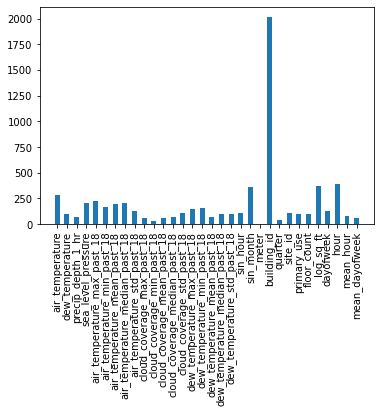

In [ ]:
expt.plot_feature_importance(feature=feature)

In [ ]:
meter_2_data = final_data[final_data.meter==2]

expt = experiment(meter_2_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour', 'mean_hour', 'mean_dayofweek']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt23', feature=feature, categorical_feature=categorical_feature,
         split_day=6, description='meter 2 building by day', n=1449, building_sample=None)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[49]	training's rmse: 1.02249	training's l2: 1.04548	valid_1's rmse: 1.55412	valid_1's l2: 2.41529


In [ ]:
meter_1_data = final_data[final_data.meter==1]

expt = experiment(meter_1_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour', 'mean_hour', 'mean_dayofweek']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt24', feature=feature, categorical_feature=categorical_feature,
         split_day=6, description='meter 1 building by day', n=1449, building_sample=None)

Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.939932	training's l2: 0.883472	valid_1's rmse: 1.41277	valid_1's l2: 1.99593


In [ ]:
meter_0_data = final_data[final_data.meter==0]

expt = experiment(meter_0_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour', 'mean_hour', 'mean_dayofweek']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt25', feature=feature, categorical_feature=categorical_feature,
         split_day=15, description='meter 0 building sample 1 by day', n=1449, building_sample=building_sample_1)

Training until validation scores don't improve for 10 rounds.
[101]	training's rmse: 0.364794	training's l2: 0.133075	valid_1's rmse: 0.451204	valid_1's l2: 0.203585
Early stopping, best iteration is:
[121]	training's rmse: 0.349491	training's l2: 0.122144	valid_1's rmse: 0.447895	valid_1's l2: 0.20061


In [ ]:
expt.run_by_day(name='expt27', feature=feature, categorical_feature=categorical_feature,
         split_day=15, description='meter 0 building sample 2 by day', n=1449, building_sample=building_sample_2)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
[101]	training's rmse: 0.339463	training's l2: 0.115235	valid_1's rmse: 0.433428	valid_1's l2: 0.18786
[202]	training's rmse: 0.292328	training's l2: 0.0854555	valid_1's rmse: 0.425083	valid_1's l2: 0.180695
Early stopping, best iteration is:
[198]	training's rmse: 0.293561	training's l2: 0.0861778	valid_1's rmse: 0.424937	valid_1's l2: 0.180571


In [ ]:
meter_3_data = final_data[final_data.meter==3]

expt = experiment(meter_3_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour', 'mean_hour', 'mean_dayofweek']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt26', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 3 building by day', n=1449, building_sample=None)

Training until validation scores don't improve for 10 rounds.
[101]	training's rmse: 1.08731	training's l2: 1.18225	valid_1's rmse: 1.26665	valid_1's l2: 1.60441
Early stopping, best iteration is:
[171]	training's rmse: 1.02515	training's l2: 1.05093	valid_1's rmse: 1.26109	valid_1's l2: 1.59035


In [ ]:
meter_2_data = final_data[final_data.meter==2]

expt = experiment(meter_2_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt28', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 2 building by day', n=1449, building_sample=None)

Training until validation scores don't improve for 10 rounds.
[101]	training's rmse: 0.971109	training's l2: 0.943053	valid_1's rmse: 1.13055	valid_1's l2: 1.27815
Early stopping, best iteration is:
[117]	training's rmse: 0.949526	training's l2: 0.901599	valid_1's rmse: 1.12734	valid_1's l2: 1.2709


In [ ]:
meter_3_data = final_data[final_data.meter==3]

expt = experiment(meter_3_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt29', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 3 building by day', n=1449, building_sample=None)

Training until validation scores don't improve for 10 rounds.
[101]	training's rmse: 1.08368	training's l2: 1.17437	valid_1's rmse: 1.2635	valid_1's l2: 1.59644
Early stopping, best iteration is:
[117]	training's rmse: 1.06284	training's l2: 1.12964	valid_1's rmse: 1.26033	valid_1's l2: 1.58842


In [ ]:
meter_1_data = final_data[final_data.meter==1]

expt = experiment(meter_1_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt30', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 1 building by day', n=1449, building_sample=None)

Training until validation scores don't improve for 10 rounds.
[101]	training's rmse: 0.828557	training's l2: 0.686507	valid_1's rmse: 0.960371	valid_1's l2: 0.922313
[202]	training's rmse: 0.741116	training's l2: 0.549253	valid_1's rmse: 0.939401	valid_1's l2: 0.882475
[303]	training's rmse: 0.69726	training's l2: 0.486171	valid_1's rmse: 0.93147	valid_1's l2: 0.867636
Early stopping, best iteration is:
[333]	training's rmse: 0.686891	training's l2: 0.471819	valid_1's rmse: 0.930381	valid_1's l2: 0.865608


In [ ]:
meter_0_data = final_data[final_data.meter==0]

expt = experiment(meter_0_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 
           'dayofweek', 'hour']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt31', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 0 building sample 1by day', n=1449, building_sample=building_sample_1)
expt.run_by_day(name='expt33', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 0 building sample 2 by day', n=1449, building_sample=building_sample_2)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
Training until validation scores don't improve for 10 rounds.
[101]	training's rmse: 0.359586	training's l2: 0.129302	valid_1's rmse: 0.449699	valid_1's l2: 0.202229
Early stopping, best iteration is:
[103]	training's rmse: 0.358232	training's l2: 0.12833	valid_1's rmse: 0.449448	valid_1's l2: 0.202003

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
Training until validation scores don't improve for 10 rounds.
[101]	training'

In [ ]:
expt.get_results().iloc[-10:]

,experiment_name,description,model,result,features,categorical_feature,train_data,val_data
33,expt24,meter 1 building by day,model/expt24-20220822-161735.pkl,None,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",6,None
34,expt26,meter 3 building by day,model/expt26-20220822-162453.pkl,None,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",15,None
35,expt25,meter 0 building sample 1 by day,model/expt25-20220822-162633.pkl,None,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",15,None
36,expt27,meter 0 building sample 2 by day,model/expt27-20220822-162826.pkl,None,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",15,None
37,expt28,meter 2 building by day,model/expt28-20220822-162950.pkl,None,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",15,None
38,expt29,meter 3 building by day,model/expt29-20220822-163049.pkl,None,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",15,None
39,expt30,meter 1 building by day,model/expt30-20220822-163351.pkl,None,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",15,None
40,expt31,meter 0 building sample 1by day,model/expt31-20220822-163511.pkl,None,"[air_temperature, dew_temperature, precip_dept...","[meter, building_id, quarter, site_id, primary...",15,None
41,expt32,meter 0 building sample 2 by day,model/expt32-20220822-163617.pkl,None,"[air_temperature, dew_temperature, precip_dept...","[meter, building_id, quarter, site_id, primary...",15,None
42,expt33,meter 0 building sample 2 by day,model/expt33-20220822-163827.pkl,None,"[air_temperature, dew_temperature, precip_dept...","[meter, building_id, quarter, site_id, primary...",15,None


In [ ]:
model_0_1 = pickle.load(open('model/expt31-20220822-163511.pkl', 'rb'))
model_0_2 = pickle.load(open('model/expt33-20220822-163827.pkl', 'rb'))
model_1 = pickle.load(open('model/expt30-20220822-163351.pkl', 'rb'))
model_2 = pickle.load(open('model/expt28-20220822-162950.pkl', 'rb'))
model_3 = pickle.load(open('model/expt29-20220822-163049.pkl', 'rb'))

In [ ]:
test_data_2017 = pickle.load(open('data/final_data/test_data_2017.pkl', 'rb'))
test_data_2018 = pickle.load(open('data/final_data/test_data_2018.pkl', 'rb'))

In [ ]:
del final_data, meter_0_data, meter_1_data, meter_2_data, meter_3_data

In [ ]:
meter_0_data_2017 = test_data_2017[test_data_2017.meter==0]
meter_0_data_2018 = test_data_2018[test_data_2018.meter==0]

meter_1_data_2017 = test_data_2017[test_data_2017.meter==1]
meter_1_data_2018 = test_data_2018[test_data_2018.meter==1]

meter_2_data_2017 = test_data_2017[test_data_2017.meter==2]
meter_2_data_2018 = test_data_2018[test_data_2018.meter==2]

meter_3_data_2017 = test_data_2017[test_data_2017.meter==3]
meter_3_data_2018 = test_data_2018[test_data_2018.meter==3]

In [ ]:
del test_data_2017, test_data_2018

In [ ]:
y_hat_meter_1 = expt.predict(model_1, [meter_1_data_2017, meter_1_data_2018], feature=feature)
y_hat_meter_2 = expt.predict(model_2, [meter_2_data_2017, meter_2_data_2018], feature=feature)
y_hat_meter_3 = expt.predict(model_3, [meter_3_data_2017, meter_3_data_2018], feature=feature)

In [ ]:
meter_0_1_data_2017 = meter_0_data_2017[meter_0_data_2017.building_id.isin(building_sample_1)]
meter_0_2_data_2017 = meter_0_data_2017[meter_0_data_2017.building_id.isin(building_sample_2)]
meter_0_1_data_2018 = meter_0_data_2018[meter_0_data_2018.building_id.isin(building_sample_1)]
meter_0_2_data_2018 = meter_0_data_2018[meter_0_data_2018.building_id.isin(building_sample_2)]

y_hat_meter_0_1 = expt.predict(model_0_1, [meter_0_1_data_2017, meter_0_1_data_2018], feature=feature)
y_hat_meter_0_2 = expt.predict(model_0_2, [meter_0_2_data_2017, meter_0_2_data_2018], feature=feature)


In [ ]:
del meter_0_1_data_2017, meter_0_2_data_2017, meter_0_1_data_2018, meter_0_2_data_2018

In [ ]:
del meter_1_data_2017,meter_1_data_2018,meter_2_data_2017,meter_2_data_2018,meter_3_data_2017,meter_3_data_2018

In [ ]:
y_hat = pd.concat([y_hat_meter_0_1, y_hat_meter_0_2, y_hat_meter_1,y_hat_meter_2,y_hat_meter_3])

In [ ]:
# y_hat = y_hat.sort_values(by='row_id')
y_hat.head(10)

,row_id,meter_reading
0,0,185.829761
1,1,83.879036
2,2,9.079160
3,3,246.250797
4,4,1365.656332
5,5,14.670382
6,6,68.765748
7,7,374.457978
8,8,128.959350
9,9,418.965041


In [ ]:
y_hat.to_csv("submission.csv", index=False, float_format="%.4f")

In [ ]:
(y_hat.meter_reading==0).sum()

551703

In [ ]:
y_hat.shape

(41697600, 2)

In [ ]:
del y_hat, y_hat_meter_0_1, y_hat_meter_0_2, y_hat_meter_1,y_hat_meter_2,y_hat_meter_3

In [ ]:
import gc
gc.collect()

18837

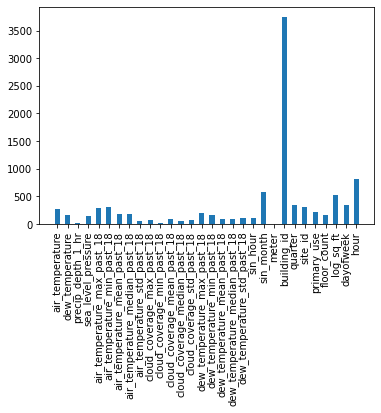

In [ ]:
expt.plot_feature_importance(feature=feature)

In [ ]:
final_data = pickle.load(open('data/final_data/final_data.pkl', 'rb'))

In [ ]:
final_data = final_data.assign(log_meter_reading=np.log1p(final_data['meter_reading']))

In [ ]:
meter_0_data = final_data[final_data.meter==0]
del final_data

In [ ]:
gc.collect()

260

In [ ]:
# meter_0_data = final_data[final_data.meter==0]

expt = experiment(meter_0_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 'month',
           'dayofweek', 'hour']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use', 'month',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt34', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 0 building sample 1by day', n=1449, building_sample=building_sample_1)
expt.run_by_day(name='expt35', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 0 building sample 2 by day', n=1449, building_sample=building_sample_2)

In [ ]:
last_submission = pd.read_csv('submission.csv')
last_submission.head()

,row_id,meter_reading
0,0,185.8298
1,1,83.8790
2,2,9.0792
3,3,246.2508
4,4,1365.6563


In [ ]:
test_df = pickle.load(open('data/input_data/test_df.pkl', 'rb'))
building_metadata_df = pickle.load(open('data/input_data/building_metadata_df.pkl', 'rb'))

In [ ]:
site_9_building = building_metadata_df[building_metadata_df.site_id==9]['building_id'].tolist()

In [ ]:
filtered_test_df = test_df[(test_df.building_id.isin(site_9_building)) & (test_df.meter==1)]
filtered_test_df.shape

(1664400, 4)

In [ ]:
filtered_test_df = filtered_test_df.merge(last_submission, on='row_id', how='left')
filtered_test_df.head()

,row_id,building_id,meter,timestamp,meter_reading
0,19663291,874,1,2017-01-01 01:00:00,341.7472
1,19663293,875,1,2017-01-01 01:00:00,234.4022
2,19663299,878,1,2017-01-01 01:00:00,51.2455
3,19663301,879,1,2017-01-01 01:00:00,169.8962
4,19663304,880,1,2017-01-01 01:00:00,206.7488


In [ ]:
train_df = pickle.load(open('data/input_data/train_df.pkl', 'rb'))

In [ ]:
train_df = train_df.merge(building_metadata_df[['building_id', 'site_id', 'primary_use']],
                          on='building_id', how='left')

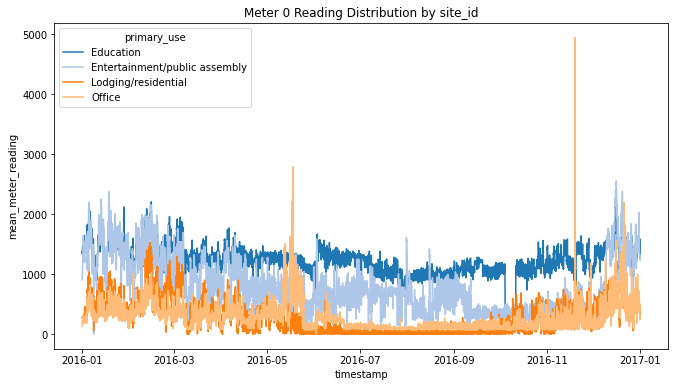

In [ ]:
plt.figure(figsize=(11,6))
# condition = (train_df.meter==0) & (train_df.site_id==9) & (train_df.primary_use=='Education') & (train_df.building_id==904)
condition = (train_df.meter==2) & (train_df.site_id==6)
sns.lineplot(data=train_df[condition].groupby(['primary_use', 'timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             hue='primary_use', x='timestamp', y='mean_meter_reading', palette='tab20')
# sns.lineplot(data=filtered_test_df.groupby(['timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
#              x='timestamp', y='mean_meter_reading')
plt.title("Meter 0 Reading Distribution by site_id")
plt.show()

## Iteration 10:

In [ ]:
#preprocessing
final_data = pickle.load(open('data/final_data/final_data.pkl', 'rb'))

In [ ]:
#remove 0 electrical reading
condition = (final_data.meter==0) & (final_data.meter_reading==0)
final_data = final_data[~condition]

#(0,904)
condition = (final_data.meter==0) & (final_data.building_id==904) & ((final_data.meter_reading>750) | (final_data.meter_reading<350))
final_data = final_data[~condition]

#(0,954)
condition = (final_data.meter==0) & (final_data.building_id==905) & ((final_data.meter_reading>2000) | (final_data.meter_reading<400))
final_data = final_data[~condition]

#(0,955)
condition = (final_data.meter==0) & (final_data.building_id==955) & ((final_data.meter_reading>2000) | (final_data.meter_reading<500))
final_data = final_data[~condition]

#(0,993)
condition = (final_data.meter==0) & (final_data.building_id==993) & (final_data.meter_reading>2000)
final_data = final_data[~condition]

#(1,778)
condition = (final_data.meter==1) & (final_data.building_id==778)
final_data = final_data[~condition]

#(1,site_id=9)
condition = (final_data.meter==1) & (final_data.site_id==9) & (final_data.meter_reading>1500)
final_data = final_data[~condition]

In [ ]:
building_sample_1 = pickle.load(open(os.path.join('model', 'building_sample_1.pkl'), 'rb'))
building_sample_2 = pickle.load(open(os.path.join('model', 'building_sample_2.pkl'), 'rb'))

In [ ]:
final_data = final_data.assign(log_meter_reading=np.log1p(final_data['meter_reading']))

In [ ]:
meter_0_data = final_data[final_data.meter==0]

In [ ]:
expt = experiment(meter_0_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 'month',
           'dayofweek', 'hour']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use', 'month',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt36', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 0 building sample 1 by day with additional preprocessing', n=1449, building_sample=building_sample_1)
expt.run_by_day(name='expt37', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 0 building sample 2 by day with additional preprocessing', n=1449, building_sample=building_sample_2)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'month', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
[101]	training's l2: 0.0794623	training's rmse: 0.281891	valid_1's l2: 0.109417	valid_1's rmse: 0.330783
[202]	training's l2: 0.0591791	training's rmse: 0.243268	valid_1's l2: 0.1001	valid_1's rmse: 0.316385
[303]	training's l2: 0.0511125	training's rmse: 0.226081	valid_1's l2: 0.0974928	valid_1's rmse: 0.312238
Early stopping, best iteration is:
[336]	training's l2: 0.0492689	training's rmse: 0.221966	valid_1's l2: 0.0969743	valid_1's rmse: 0.311407
Training until validation scores don't improve for 10 rounds.
[101]	training's l2: 0.072919	training's rmse: 0.270035	valid_1's l2: 0.100242	valid_1's rmse: 0.31661
[202]	training's l2: 0.0558113	training's rmse: 0.236244	valid_1's l2: 0.0909618	valid_1's rmse: 0.301599
Early stopping, best iteration is:
[250]	training's l2: 0.0514101	training's rmse: 0.226738	valid_1's l2: 0.0893403	valid_1's rmse: 0.298898


In [ ]:
expt.get_results().iloc[-5:]

,experiment_name,description,model,result,features,categorical_feature,train_data,val_data
40,expt31,meter 0 building sample 1by day,model/expt31-20220822-163511.pkl,None,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",15,None
41,expt32,meter 0 building sample 2 by day,model/expt32-20220822-163617.pkl,None,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",15,None
42,expt33,meter 0 building sample 2 by day,model/expt33-20220822-163827.pkl,None,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",15,None
43,expt36,meter 0 building sample 1 by day with addition...,model/expt36-20220823-031027.pkl,None,"[air_temperature, dew_temperature, precip_dept...","[meter, building_id, quarter, site_id, primary...",15,None
44,expt37,meter 0 building sample 2 by day with addition...,model/expt37-20220823-031215.pkl,None,"[air_temperature, dew_temperature, precip_dept...","[meter, building_id, quarter, site_id, primary...",15,None


In [ ]:
model_0_1 = pickle.load(open('model/expt36-20220823-031027.pkl', 'rb'))
model_0_2 = pickle.load(open('model/expt37-20220823-031215.pkl', 'rb'))

In [ ]:
test_data_2017 = pickle.load(open('data/final_data/test_data_2017.pkl', 'rb'))
test_data_2018 = pickle.load(open('data/final_data/test_data_2018.pkl', 'rb'))

meter_0_data_2017 = test_data_2017[test_data_2017.meter==0]
meter_0_data_2018 = test_data_2018[test_data_2018.meter==0]

# meter_1_data_2017 = test_data_2017[test_data_2017.meter==1]
# meter_1_data_2018 = test_data_2018[test_data_2018.meter==1]

# meter_2_data_2017 = test_data_2017[test_data_2017.meter==2]
# meter_2_data_2018 = test_data_2018[test_data_2018.meter==2]

# meter_3_data_2017 = test_data_2017[test_data_2017.meter==3]
# meter_3_data_2018 = test_data_2018[test_data_2018.meter==3]

In [ ]:
del test_data_2017, test_data_2018

In [ ]:
[].copy()

[]

In [ ]:
feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 'month',
           'dayofweek', 'hour']

expt = experiment([])

In [ ]:
meter_0_1_data_2017 = meter_0_data_2017[meter_0_data_2017.building_id.isin(building_sample_1)]
meter_0_2_data_2017 = meter_0_data_2017[meter_0_data_2017.building_id.isin(building_sample_2)]
meter_0_1_data_2018 = meter_0_data_2018[meter_0_data_2018.building_id.isin(building_sample_1)]
meter_0_2_data_2018 = meter_0_data_2018[meter_0_data_2018.building_id.isin(building_sample_2)]

y_hat_meter_0_1 = expt.predict(model_0_1, [meter_0_1_data_2017, meter_0_1_data_2018], feature=feature)
y_hat_meter_0_2 = expt.predict(model_0_2, [meter_0_2_data_2017, meter_0_2_data_2018], feature=feature)

In [ ]:
last_submission = pd.read_csv('submission.csv')

In [ ]:
y_hat_modified = pd.concat([y_hat_meter_0_1,y_hat_meter_0_2])

In [ ]:
y_hat_modified.head()

,row_id,meter_reading
0,0,158.625887
5,5,12.088950
6,6,86.449482
9,9,414.025919
10,10,59.412803


In [ ]:
last_submission.head(11)

,row_id,meter_reading
0,0,185.8298
1,1,83.8790
2,2,9.0792
3,3,246.2508
4,4,1365.6563
5,5,14.6704
6,6,68.7657
7,7,374.4580
8,8,128.9594
9,9,418.9650


In [ ]:
del y_hat_meter_0_1,y_hat_meter_0_2,meter_0_1_data_2017,meter_0_2_data_2017,meter_0_1_data_2018,meter_0_2_data_2018

In [ ]:
last_submission = last_submission.merge(y_hat_modified, on='row_id', how='left')

In [ ]:
last_submission.head()

,row_id,meter_reading_x,meter_reading_y
0,0,185.8298,158.625887
1,1,83.8790,68.377625
2,2,9.0792,8.715843
3,3,246.2508,255.869653
4,4,1365.6563,1233.830845


In [ ]:
last_submission['meter_reading_y'] = last_submission['meter_reading_y'].fillna(last_submission['meter_reading_x'])

In [ ]:
last_submission.drop(columns='meter_reading_x', inplace=True)

In [ ]:
last_submission = last_submission.rename(columns={'meter_reading_y':'meter_reading'}).sort_values(by='row_id')

In [ ]:
last_submission.to_csv('submission_with_modified_0.csv', header=False, float_format="%.4f")

In [ ]:
last_submission.isna().sum()


row_id           0
meter_reading    0
dtype: int64

In [ ]:
last_submission.dtypes

row_id             int64
meter_reading    float64
dtype: object

In [ ]:
last_submission = compress(last_submission)

Memory usage reduced to  636.255 MB: Memory reduction by 33.333298406717645%


In [ ]:
last_submission.to_csv('submission_with_modified_0.csv', index=False, float_format="%.4f")

In [ ]:
last_submission.dtypes

row_id             int32
meter_reading    float32
dtype: object

In [ ]:
del last_submission

In [ ]:
import gc
gc.collect()

482

In [ ]:
meter_1_data = final_data[final_data.meter==1]

In [ ]:
expt = experiment(meter_1_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 'month',
           'dayofweek', 'hour']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use', 'month',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt40', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 1 building by day with additional preprocessing', n=1449, building_sample=None)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'month', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
[101]	training's rmse: 0.846222	training's l2: 0.716091	valid_1's rmse: 0.983802	valid_1's l2: 0.967866
[202]	training's rmse: 0.7407	training's l2: 0.548636	valid_1's rmse: 0.949763	valid_1's l2: 0.90205
[303]	training's rmse: 0.690136	training's l2: 0.476288	valid_1's rmse: 0.941279	valid_1's l2: 0.886007
Early stopping, best iteration is:
[331]	training's rmse: 0.679996	training's l2: 0.462394	valid_1's rmse: 0.939853	valid_1's l2: 0.883323


In [ ]:
test_data_2017 = pickle.load(open('data/final_data/test_data_2017.pkl', 'rb'))
test_data_2018 = pickle.load(open('data/final_data/test_data_2018.pkl', 'rb'))

meter_1_data_2017 = test_data_2017[test_data_2017.meter==1]
meter_1_data_2018 = test_data_2018[test_data_2018.meter==1]

In [ ]:
del test_data_2017, test_data_2018

In [ ]:
expt.get_results().iloc[-2:]

,experiment_name,description,model,result,features,categorical_feature,train_data,val_data
44,expt37,meter 0 building sample 2 by day with addition...,model/expt37-20220823-031215.pkl,None,"['air_temperature', 'dew_temperature', 'precip...","['meter', 'building_id', 'quarter', 'site_id',...",15,None
45,expt40,meter 1 building by day with additional prepro...,model/expt40-20220823-050308.pkl,None,"[air_temperature, dew_temperature, precip_dept...","[meter, building_id, quarter, site_id, primary...",15,None


In [ ]:
model_1 = pickle.load(open('model/expt40-20220823-050308.pkl', 'rb'))

In [ ]:
y_meter_1 = expt.predict(model_1, [meter_1_data_2017, meter_1_data_2018], feature=feature)

In [ ]:
last_submission = pd.read_csv('submission_with_modified_0.csv')

In [ ]:
y_meter_1 = compress(y_meter_1)

Memory usage reduced to  133.132 MB: Memory reduction by 19.999999999999993%


In [ ]:
last_submission = last_submission.merge(y_meter_1, on='row_id', how='left')
last_submission['meter_reading_y'] = last_submission['meter_reading_y'].fillna(last_submission['meter_reading_x'])
last_submission.drop(columns='meter_reading_x', inplace=True)
last_submission = last_submission.rename(columns={'meter_reading_y':'meter_reading'})
assert last_submission.isna().sum().sum() == 0
last_submission.head()

,row_id,meter_reading
0,0,158.625900
1,1,68.377602
2,2,8.715800
3,3,255.869705
4,4,1233.830811


In [ ]:
last_submission.to_csv('submission_with_modified_0_1.csv', index=False, float_format="%.4f")

In [ ]:
final_data.head()

,meter,building_id,timestamp,meter_reading,quarter,site_id,primary_use,square_feet,year_built,floor_count,...,precip_depth_1_hr_mean_past_18,precip_depth_1_hr_median_past_18,precip_depth_1_hr_std_past_18,month,dayofweek,hour,sin_hour,sin_month,sin_wind_direction,log_meter_reading
0,0,0,2016-05-20 18:00:00,232.753006,2,0,1,7432,109,1,...,-0.111084,0.0,0.323486,5,4,18,0.965820,0.991211,1.000000,5.454265
1,0,0,2016-05-20 19:00:00,277.802002,2,0,1,7432,109,1,...,-0.111084,0.0,0.323486,5,4,19,0.866211,0.991211,1.000000,5.630502
2,0,0,2016-05-20 20:00:00,238.895996,2,0,1,7432,109,1,...,-0.111084,0.0,0.323486,5,4,20,0.707031,0.991211,1.000000,5.480206
3,0,0,2016-05-20 21:00:00,240.944000,2,0,1,7432,109,1,...,-0.111084,0.0,0.323486,5,4,21,0.500000,0.991211,-0.173706,5.488706
4,0,0,2016-05-20 22:00:00,252.546997,2,0,1,7432,109,1,...,-0.111084,0.0,0.323486,5,4,22,0.258789,0.991211,1.000000,5.535549


In [ ]:
final_data_train = final_data[final_data.timestamp.dt.day<=15]
final_data_val = final_data[final_data.timestamp.dt.day>15]

In [ ]:
building_hour_mean = final_data_train.groupby(['building_id', 'month', 'hour'])\
                                  .agg(building_hour_mean=('meter_reading', 'mean')).reset_index()
meter_hour_mean = final_data_train.groupby(['meter', 'month', 'hour'])\
                                   .agg(meter_hour_mean=('meter_reading', 'mean')).reset_index()

In [ ]:
building_hour_mean.shape, meter_hour_mean.shape

((398571, 4), (1152, 4))

In [ ]:
building_hour_mean = compress(building_hour_mean)
meter_hour_mean = compress(meter_hour_mean)

Memory usage reduced to    3.041 MB: Memory reduction by 71.4272291647092%
Memory usage reduced to    0.008 MB: Memory reduction by 74.19354838709677%


In [ ]:
final_data = final_data.merge(building_hour_mean, on=['building_id', 'month', 'hour'], how='left')
final_data = final_data.merge(meter_hour_mean, on=['meter', 'month', 'hour'], how='left')

In [ ]:
final_data['building_hour_mean'] = final_data['building_hour_mean'].fillna(final_data['meter_hour_mean'])

In [ ]:
final_data['building_hour_mean'] = np.log1p(final_data['building_hour_mean'])
final_data['meter_hour_mean'] = np.log1p(final_data['meter_hour_mean'])

In [ ]:
pickle.dump(final_data, open('data/final_data/final_data.pkl', 'wb'))

In [ ]:
pickle.dump(building_hour_mean, open('data/final_data/building_hour_mean.pkl', 'wb'))
pickle.dump(meter_hour_mean, open('data/final_data/meter_hour_mean.pkl', 'wb'))

## Iteration 11:

In [ ]:
final_data = pickle.load(open('data/final_data/final_data.pkl', 'rb'))
meter_0_data = final_data[final_data.meter==0].copy()

In [ ]:
building_sample_1 = pickle.load(open(os.path.join('model', 'building_sample_1.pkl'), 'rb'))
building_sample_2 = pickle.load(open(os.path.join('model', 'building_sample_2.pkl'), 'rb'))

In [ ]:
meter_0_data.columns

Index(['meter', 'building_id', 'timestamp', 'meter_reading', 'quarter',
       'site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count',
       'log_sq_ft', 'year_built_label', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'air_temperature_max_past_18',
       'air_temperature_min_past_18', 'air_temperature_mean_past_18',
       'air_temperature_median_past_18', 'air_temperature_std_past_18',
       'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
       'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
       'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
       'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
       'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
       'precip_depth_1_hr_max_past_18', 'precip_depth_1_hr_min_past_18',
       'precip_depth_1_hr_mean_past_18', 'precip_depth_1_hr_median_past_

In [ ]:
expt = experiment(meter_0_data)

feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 'month',
           'dayofweek', 'hour', 'building_hour_mean', 'meter_hour_mean']
           
categorical_feature = ['meter', 'building_id', 'quarter',
                       'site_id', 'primary_use', 'month',
                       'dayofweek', 'hour']
expt.run_by_day(name='expt41', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 0 building sample 1 by day with mean reading added', n=1449, building_sample=building_sample_1)
expt.run_by_day(name='expt42', feature=feature, categorical_feature=categorical_feature,
                split_day=15, description='meter 0 building sample 2 by day with mean reading added', n=1449, building_sample=building_sample_2)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'month', 'primary_use', 'quarter', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
[101]	training's l2: 0.0568798	training's rmse: 0.238495	valid_1's l2: 0.116886	valid_1's rmse: 0.341886
[202]	training's l2: 0.0455155	training's rmse: 0.213344	valid_1's l2: 0.113314	valid_1's rmse: 0.336622
Early stopping, best iteration is:
[199]	training's l2: 0.045722	training's rmse: 0.213827	valid_1's l2: 0.113305	valid_1's rmse: 0.336608
Training until validation scores don't improve for 10 rounds.
[101]	training's l2: 0.0511701	training's rmse: 0.226208	valid_1's l2: 0.108163	valid_1's rmse: 0.328882
[202]	training's l2: 0.0424053	training's rmse: 0.205925	valid_1's l2: 0.10477	valid_1's rmse: 0.323681
Early stopping, best iteration is:
[261]	training's l2: 0.0396244	training's rmse: 0.199059	valid_1's l2: 0.104394	valid_1's rmse: 0.3231


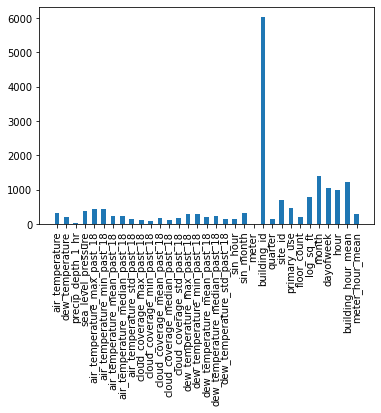

In [ ]:
expt.plot_feature_importance(feature=feature)

In [ ]:
expt.curr_model.n_features_

33

In [ ]:
len(feature)

33

In [ ]:
del meter_0_data, final_data

In [ ]:
model_0_1 = pickle.load(open('model/expt41-20220823-054637.pkl', 'rb'))
model_0_2 = pickle.load(open('model/expt42-20220823-054853.pkl', 'rb'))

test_data_2017 = pickle.load(open('data/final_data/test_data_2017.pkl', 'rb'))
test_data_2018 = pickle.load(open('data/final_data/test_data_2018.pkl', 'rb'))

meter_0_data_2017 = test_data_2017[test_data_2017.meter==0]
meter_0_data_2018 = test_data_2018[test_data_2018.meter==0]

del test_data_2017, test_data_2018

meter_0_1_data_2017 = meter_0_data_2017[meter_0_data_2017.building_id.isin(building_sample_1)]
meter_0_2_data_2017 = meter_0_data_2017[meter_0_data_2017.building_id.isin(building_sample_2)]
meter_0_1_data_2018 = meter_0_data_2018[meter_0_data_2018.building_id.isin(building_sample_1)]
meter_0_2_data_2018 = meter_0_data_2018[meter_0_data_2018.building_id.isin(building_sample_2)]

del meter_0_data_2017, meter_0_data_2018

In [ ]:
model_0_1.n_features_

33

In [ ]:
feature = ['air_temperature', 
           'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
           'air_temperature_max_past_18',
           'air_temperature_min_past_18', 'air_temperature_mean_past_18',
           'air_temperature_median_past_18', 'air_temperature_std_past_18',
           'cloud_coverage_max_past_18', 'cloud_coverage_min_past_18',
           'cloud_coverage_mean_past_18', 'cloud_coverage_median_past_18',
           'cloud_coverage_std_past_18', 'dew_temperature_max_past_18',
           'dew_temperature_min_past_18', 'dew_temperature_mean_past_18',
           'dew_temperature_median_past_18', 'dew_temperature_std_past_18',
           'sin_hour', 'sin_month', 
           'meter', 'building_id', 'quarter',
           'site_id', 'primary_use', 'floor_count',
           'log_sq_ft', 'month',
           'dayofweek', 'hour', 'building_hour_mean', 'meter_hour_mean']

In [ ]:
building_hour_mean = pickle.load(open('data/final_data/building_hour_mean.pkl', 'rb'))
meter_hour_mean = pickle.load(open('data/final_data/meter_hour_mean.pkl', 'rb'))

In [ ]:
building_hour_mean['building_hour_mean'] = np.log1p(building_hour_mean['building_hour_mean'])
meter_hour_mean['meter_hour_mean'] = np.log1p(meter_hour_mean['meter_hour_mean'])

In [ ]:
meter_0_1_data_2017.shape, meter_0_2_data_2017.shape, meter_0_1_data_2018.shape, meter_0_2_data_2018.shape

((6184560, 45), (6193320, 45), (6184560, 45), (6193320, 45))

In [ ]:
meter_0_1_data_2017 = meter_0_1_data_2017.merge(building_hour_mean, on=['building_id', 'month', 'hour'], how='left')
meter_0_1_data_2017 = meter_0_1_data_2017.merge(meter_hour_mean, on=['meter', 'month', 'hour'], how='left')

meter_0_2_data_2017 = meter_0_2_data_2017.merge(building_hour_mean, on=['building_id', 'month', 'hour'], how='left')
meter_0_2_data_2017 = meter_0_2_data_2017.merge(meter_hour_mean, on=['meter', 'month', 'hour'], how='left')

meter_0_1_data_2018 = meter_0_1_data_2018.merge(building_hour_mean, on=['building_id', 'month', 'hour'], how='left')
meter_0_1_data_2018 = meter_0_1_data_2018.merge(meter_hour_mean, on=['meter', 'month', 'hour'], how='left')

meter_0_2_data_2018 = meter_0_2_data_2018.merge(building_hour_mean, on=['building_id', 'month', 'hour'], how='left')
meter_0_2_data_2018 = meter_0_2_data_2018.merge(meter_hour_mean, on=['meter', 'month', 'hour'], how='left')

In [ ]:
meter_0_1_data_2017['building_hour_mean'] = meter_0_1_data_2017['building_hour_mean'].fillna(meter_0_1_data_2017['meter_hour_mean'])
meter_0_2_data_2017['building_hour_mean'] = meter_0_2_data_2017['building_hour_mean'].fillna(meter_0_2_data_2017['meter_hour_mean'])
meter_0_1_data_2018['building_hour_mean'] = meter_0_1_data_2018['building_hour_mean'].fillna(meter_0_1_data_2018['meter_hour_mean'])
meter_0_2_data_2018['building_hour_mean'] = meter_0_2_data_2018['building_hour_mean'].fillna(meter_0_2_data_2018['meter_hour_mean'])

In [ ]:
meter_0_1_data_2018.isna().sum().sum()

0

In [ ]:
y_hat_meter_0_1 = expt.predict(model_0_1, [meter_0_1_data_2017, meter_0_1_data_2018], feature=feature)
y_hat_meter_0_2 = expt.predict(model_0_2, [meter_0_2_data_2017, meter_0_2_data_2018], feature=feature)

In [ ]:
y_meter_0 = compress(pd.concat([y_hat_meter_0_1, y_hat_meter_0_2]))

Memory usage reduced to  377.743 MB: Memory reduction by 20.00004235681807%


In [ ]:
y_meter_0.head(10)

,row_id,meter_reading
0,0,115.482918
1,5,65.902763
2,6,88.305634
3,9,164.606918
4,10,70.232269
5,13,185.728668
6,14,130.240036
7,17,126.019051
8,19,110.417206
9,22,114.855873


In [ ]:
last_submission = pd.read_csv('submission_with_modified_0_1.csv')

In [ ]:
last_submission = last_submission.merge(y_meter_0, on='row_id', how='left')
last_submission['meter_reading_y'] = last_submission['meter_reading_y'].fillna(last_submission['meter_reading_x'])
last_submission.drop(columns='meter_reading_x', inplace=True)
last_submission = last_submission.rename(columns={'meter_reading_y':'meter_reading'})
assert last_submission.isna().sum().sum() == 0
last_submission.head()

,row_id,meter_reading
0,0,115.482918
1,1,104.433708
2,2,60.339642
3,3,100.832085
4,4,362.065948


In [ ]:
last_submission.to_csv('submission_with_modified_0_with_added_mean.csv', index=False, float_format="%.4f")

In [ ]:
# Inference Pipeline for deployment:
class deployment():
    def __init__(self, path_list):
        self.model_0_1 = pickle.load(path_list[0])
        self.model_0_2 = pickle.load(path_list[1])
        self.model_1 = pickle.load(path_list[2])
        self.model_2 = pickle.load(path_list[3])
    def preprocess(self, x):
        building_data = x[0]
        weather_data = x[1]
        p_weather_data = weather_preprocessing_pipleine(df=weather_data, 
                                                        year=[2016], 
                                                        apply_offset=True, 
                                                        offsets=None)
        p_building_data = preprocess_building_data(building_data, train=True)

        fe_weather_data = weather_fe_pipeline(data=p_weather_data)
        fe_building_data = building_fe_pipeline(data=p_building_data)

        final_data = prepare_data(building_data=fe_weather_data,
                                  weather_data=fe_building_data)
